# [주피터 노트북 실행하기]

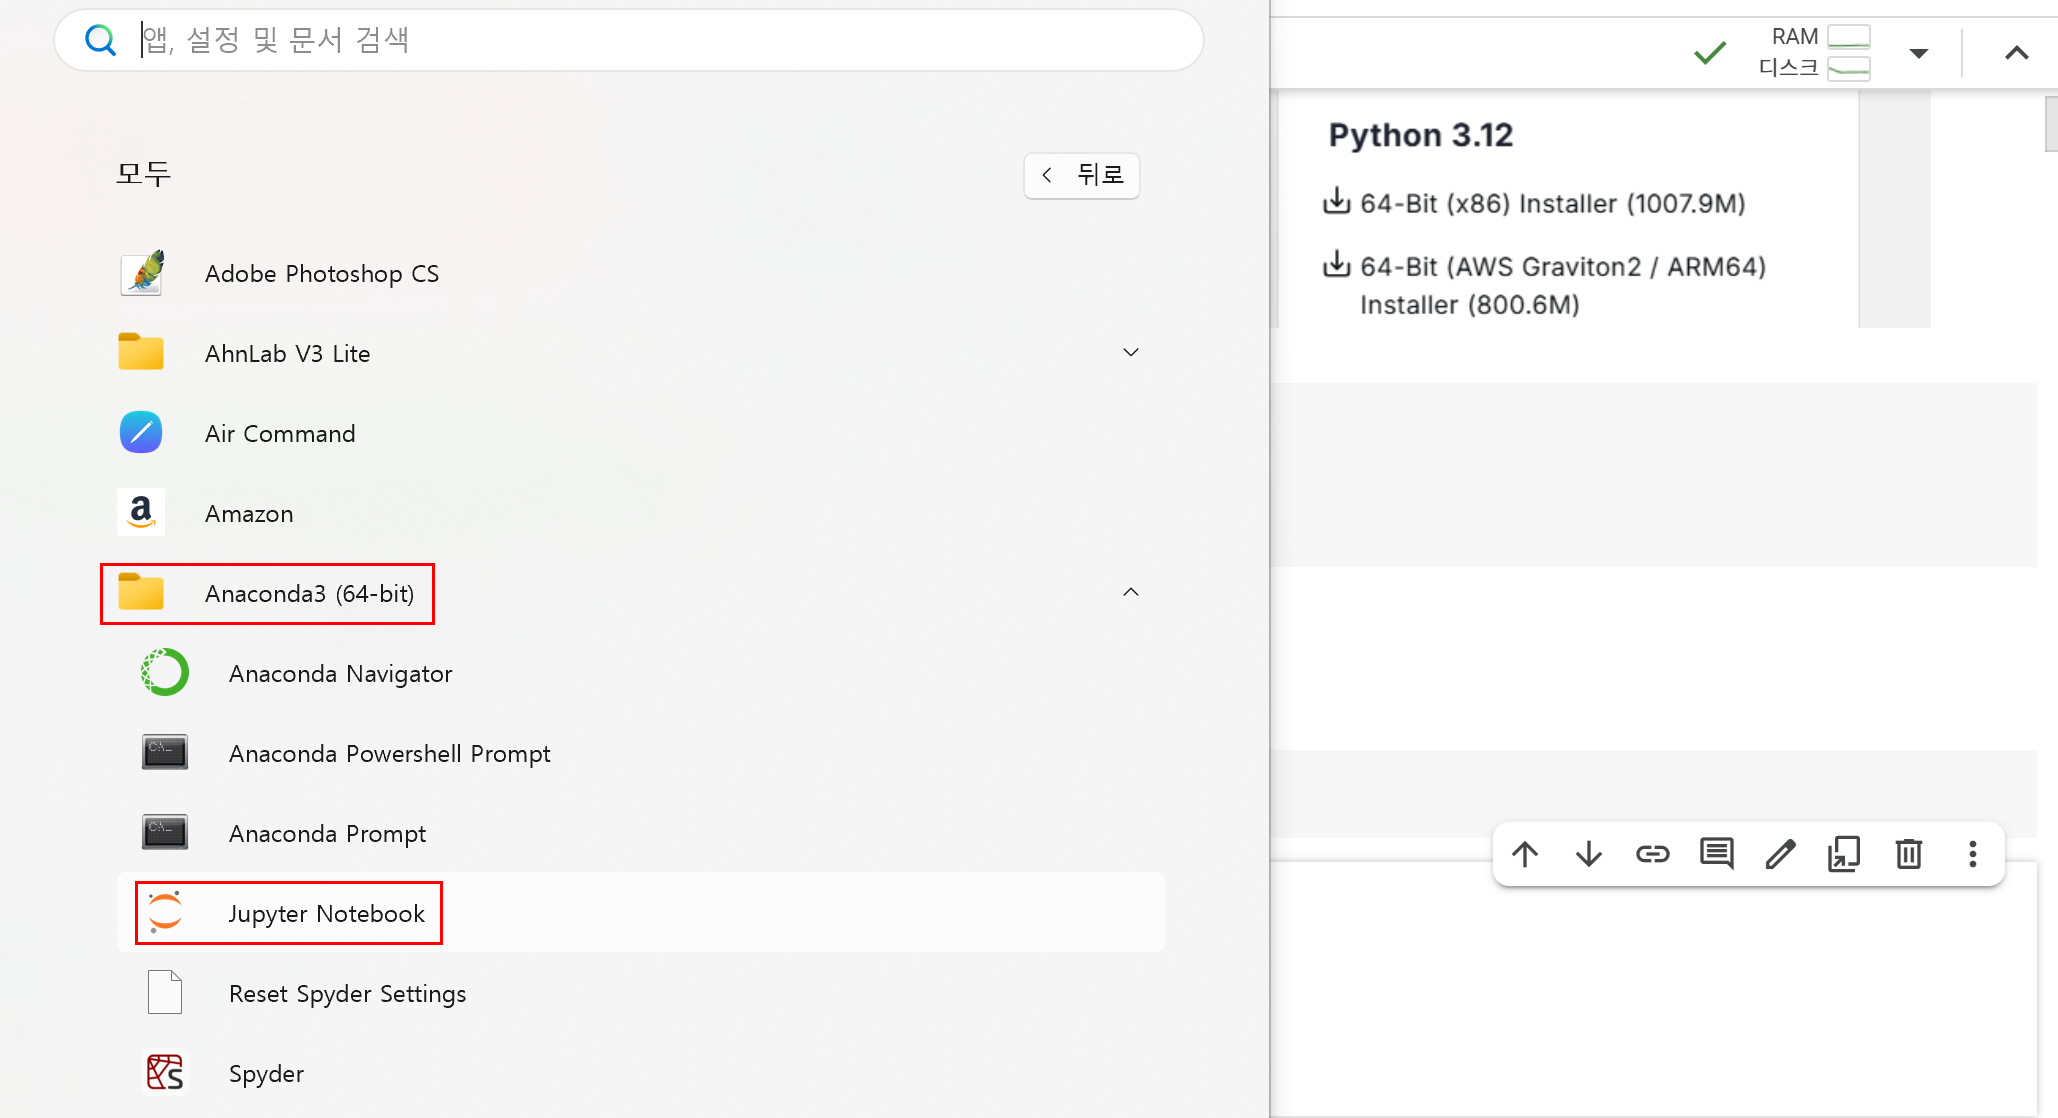

- 크롬으로 자동으로 창 열림
- 터미널 창은 닫으면 실행 안됨 재시작해야함
- 크롬이 아닌경우 주소 복사하여 크롬에서 열기

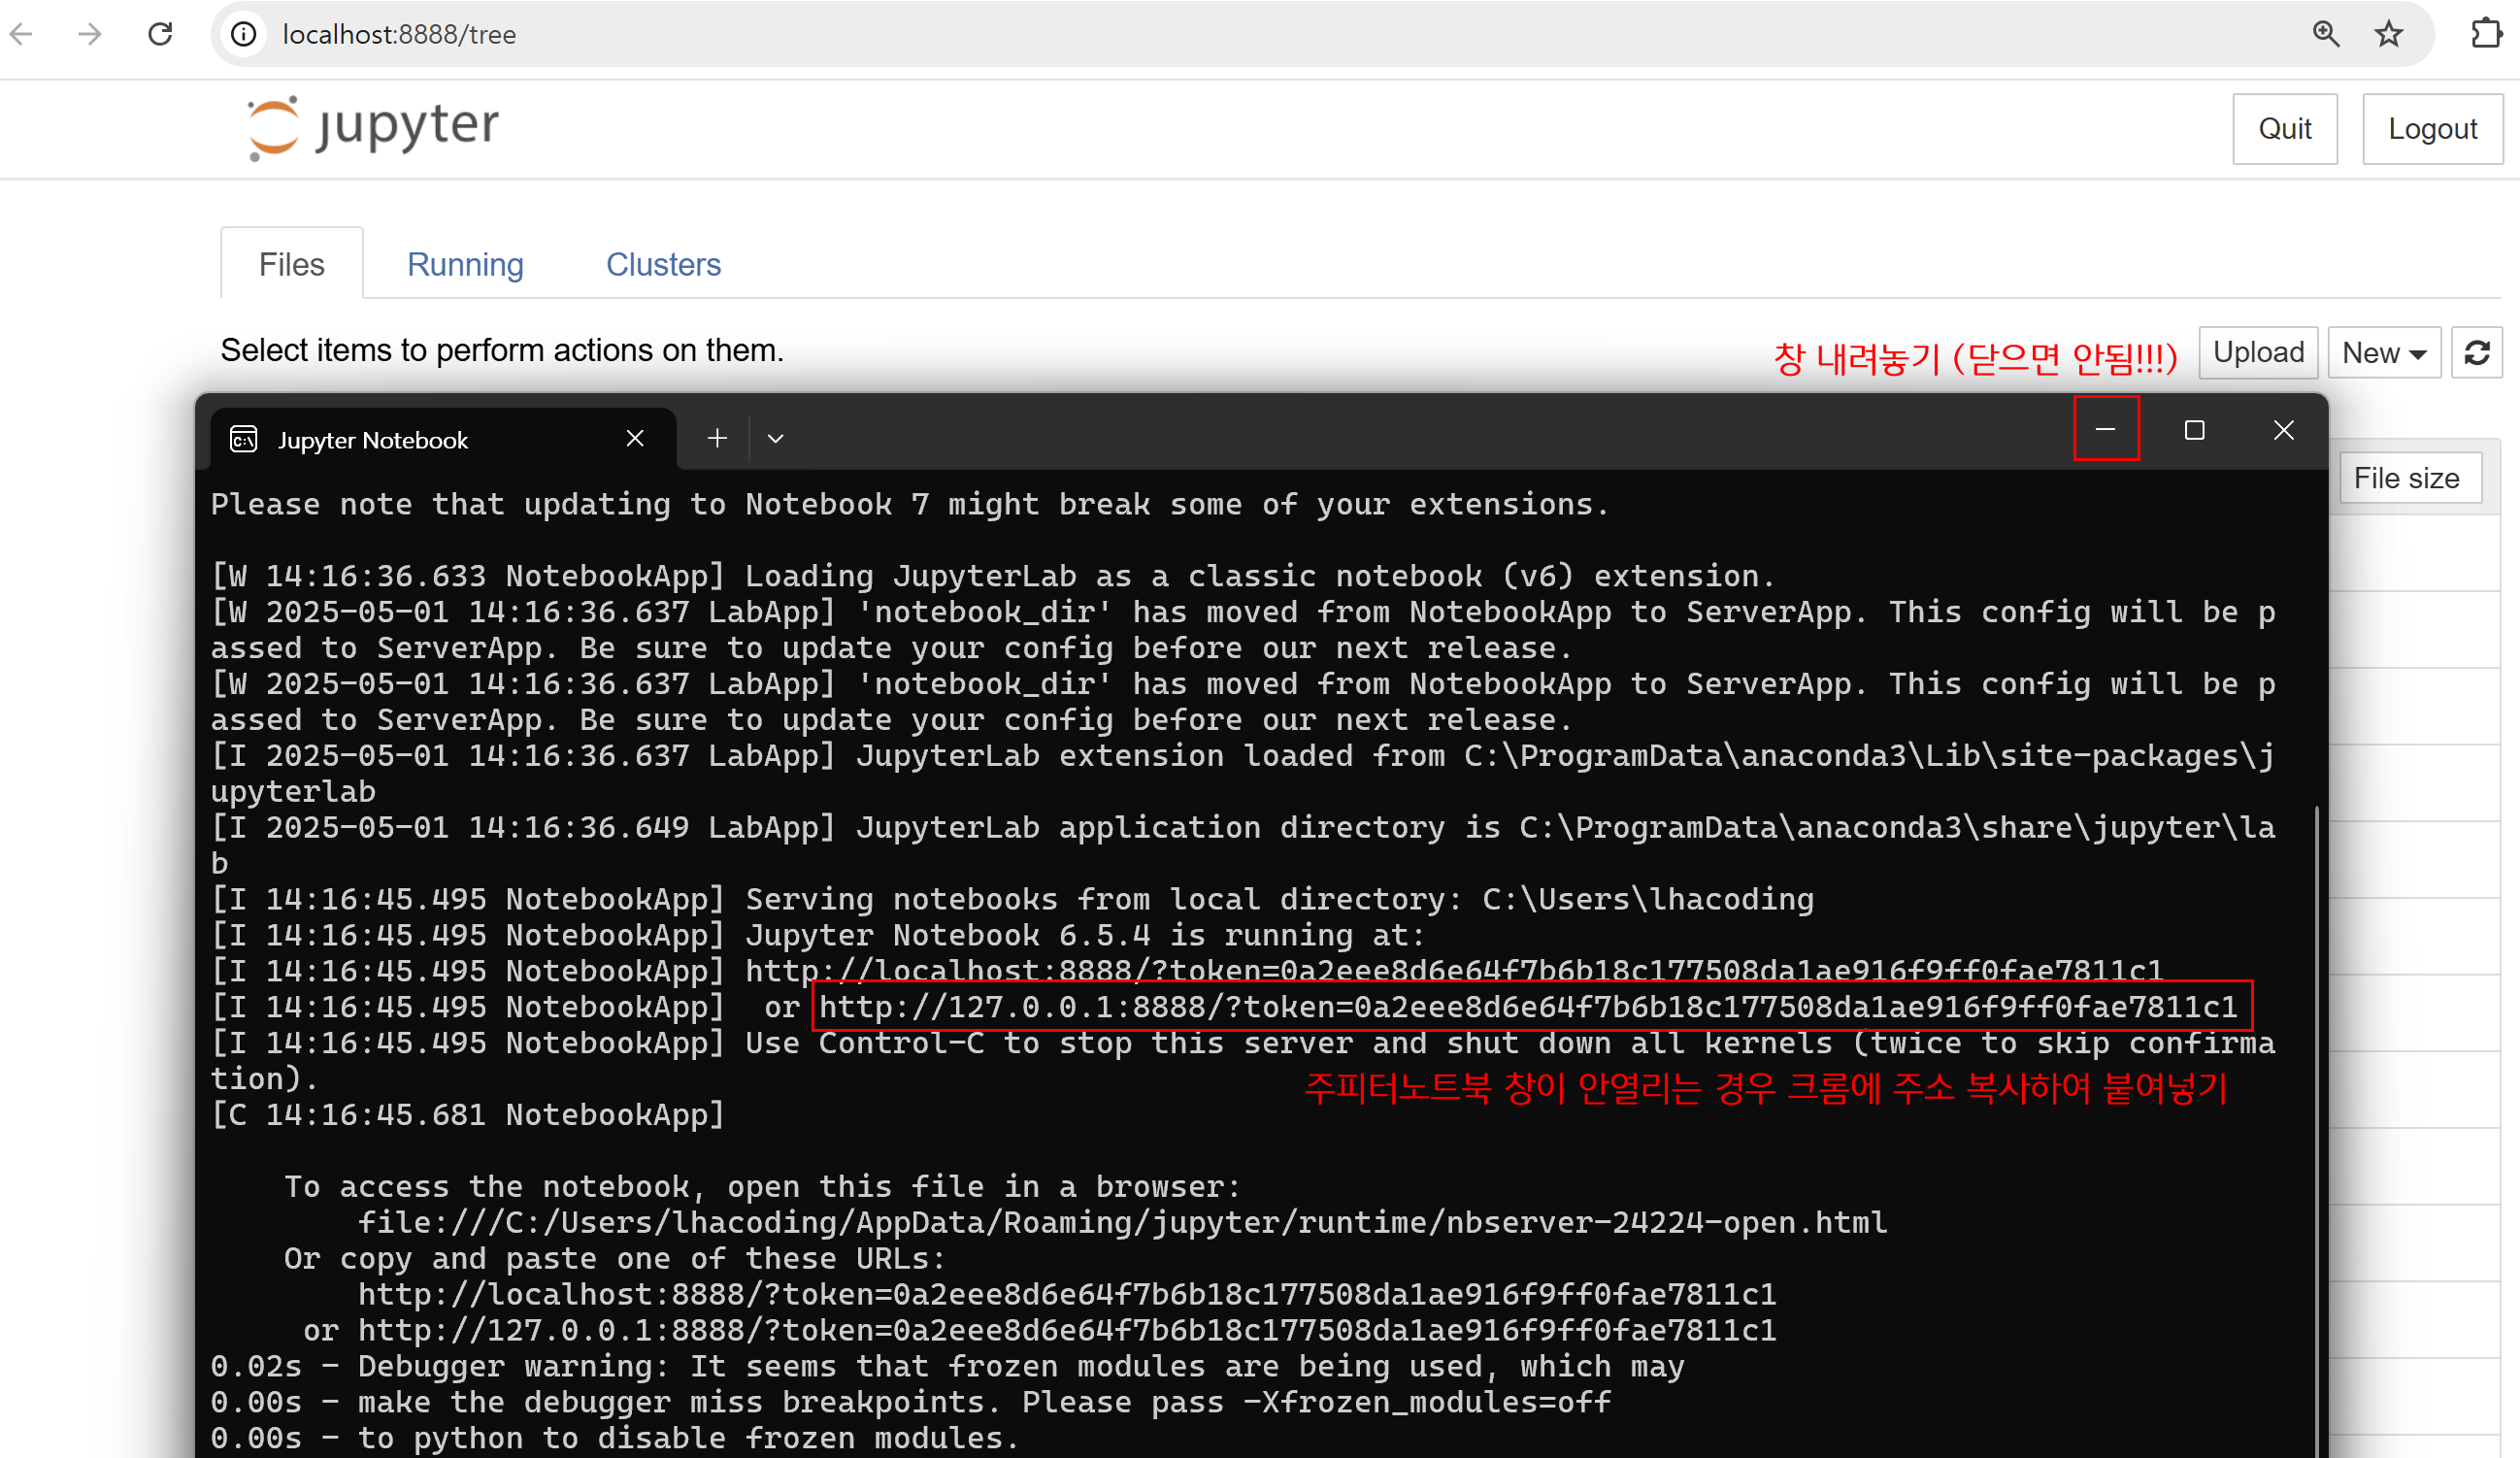

# [파이썬 실행하기]

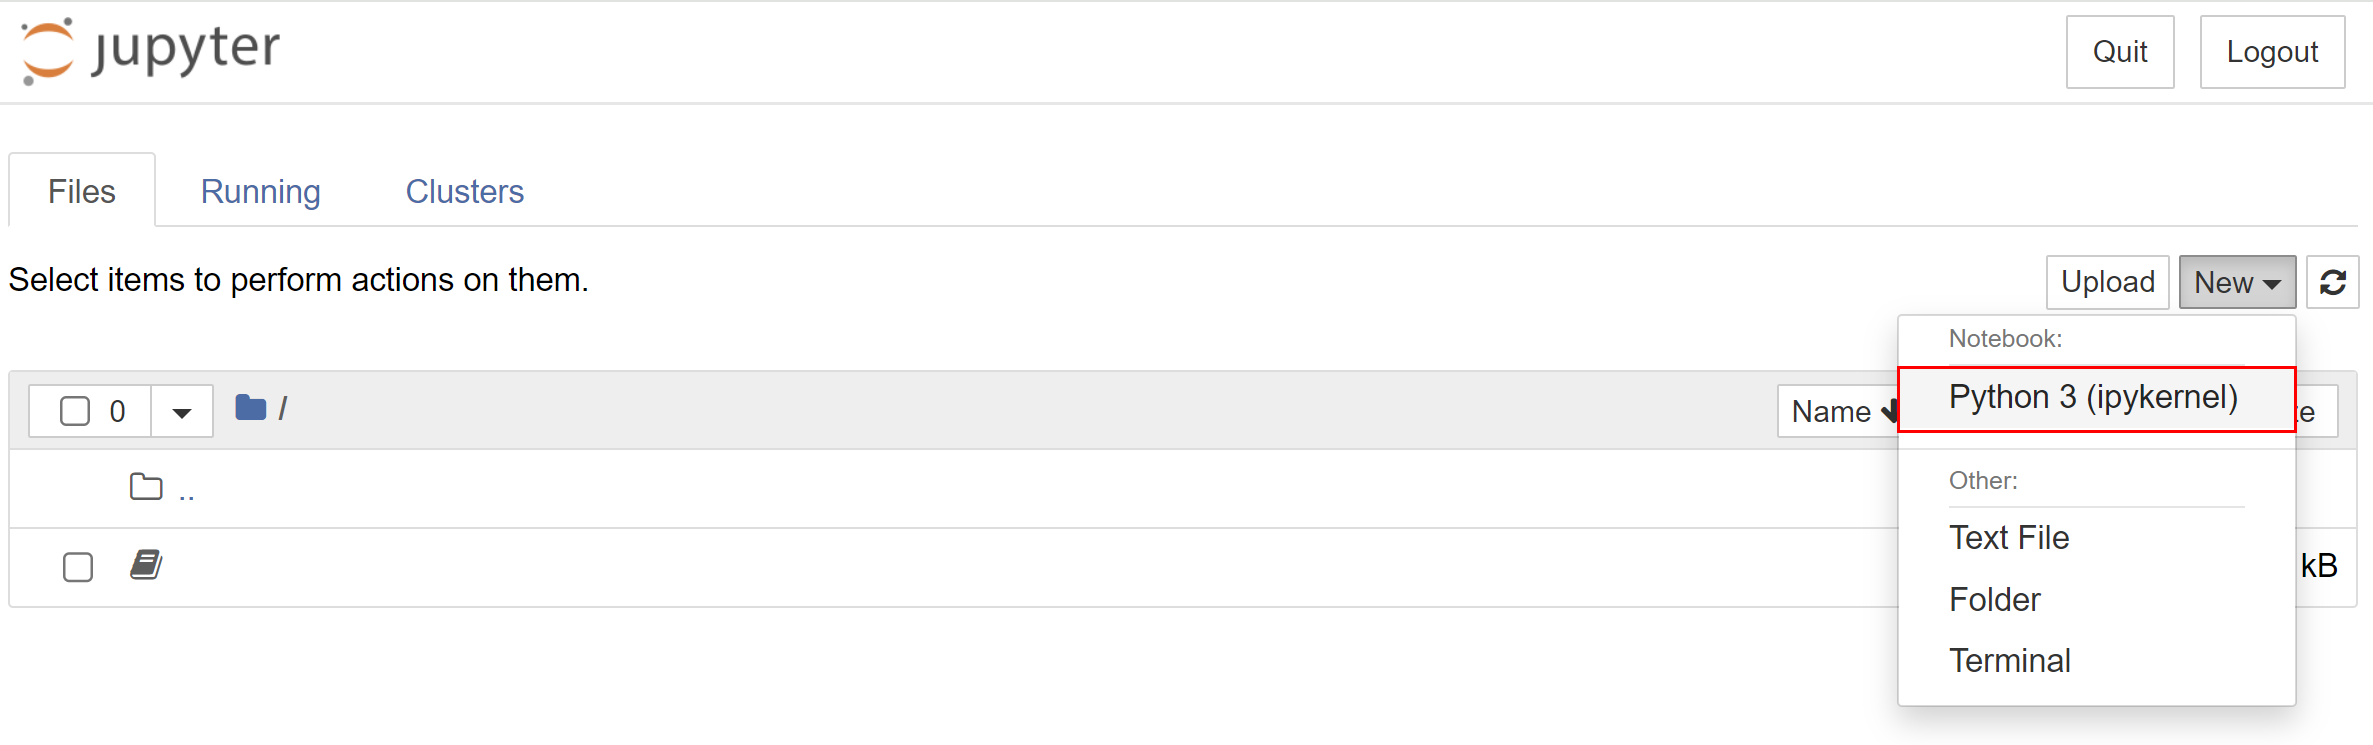

## [RoboCam Library 살펴보기]

## [RoboCam import 하기]

- 코드 복사하여 붙여넣기

```python
from RoboCam.robocam import *
rCam = RoboCam()
```

[실행 결과]
- 메시지 출력되면 완료

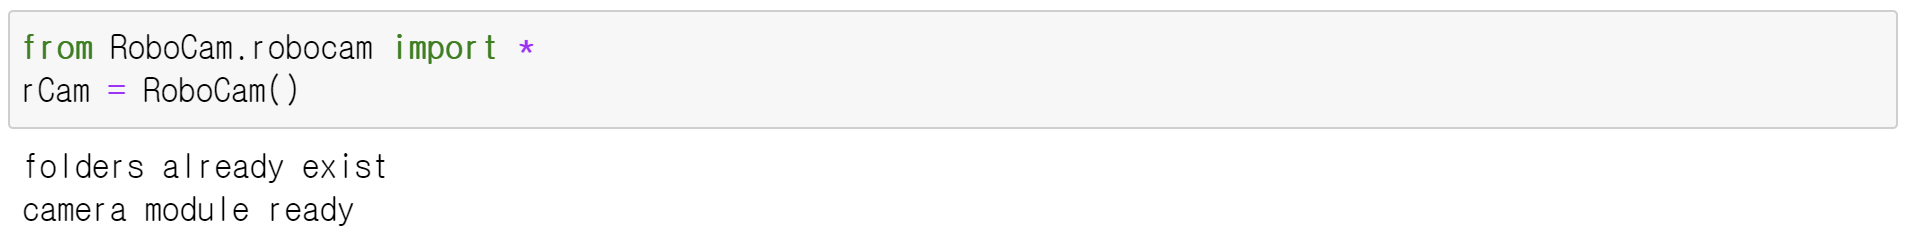

In [ ]:
print(help(rCam))

## [폴더 경로]

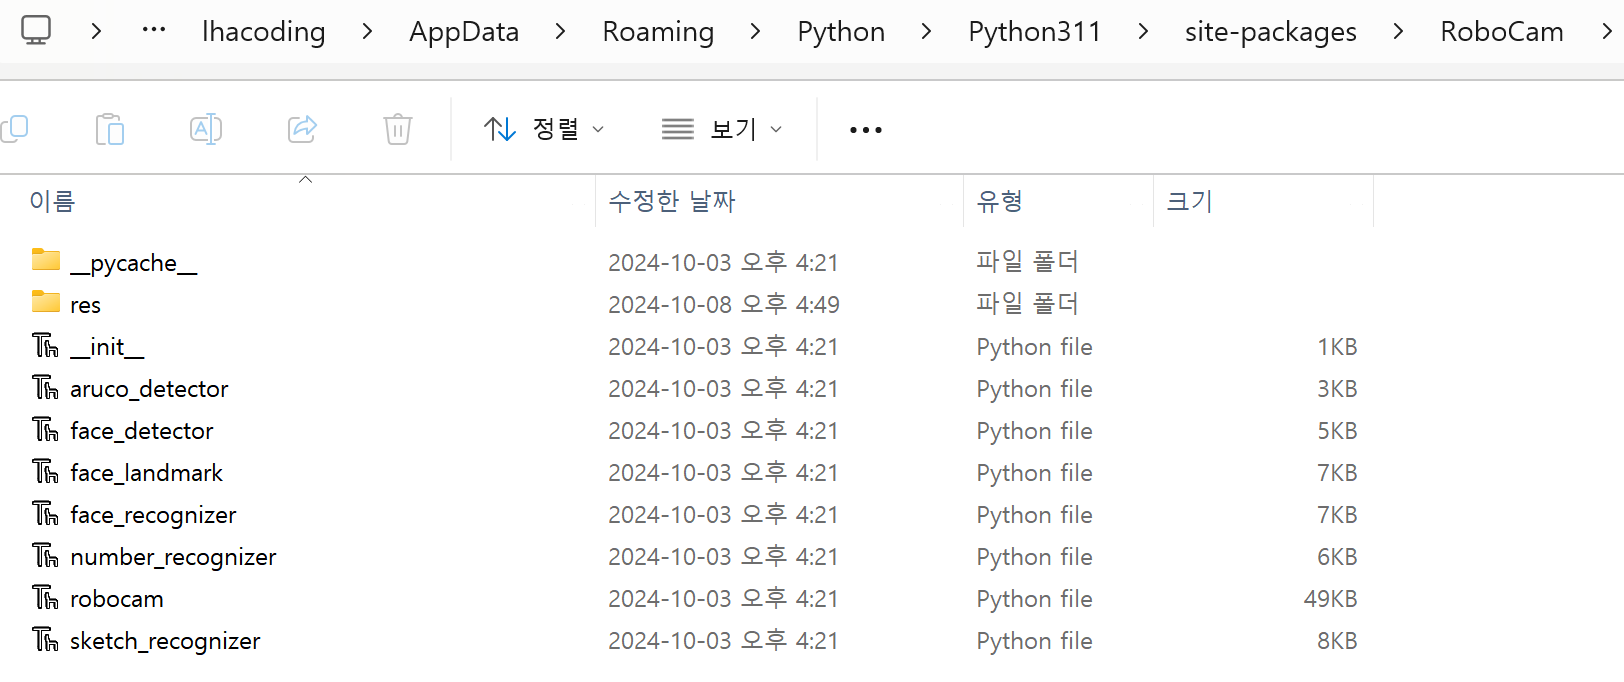

In [ ]:
    def WebcamStreamInit(self, width:int = 640, height:int = 480):
        if self.__cameraStreamInitFlag is True:
            print("Camera stream is aready initialized.")
            return
        if self.__webcamStreamInitFlag is True:
            print("Webcam stream is aready initialized.")
            return

        while True:
            try:
                self.__webcam = cv2.VideoCapture(0)
                if self.__webcam.isOpened() == False:
                    time.sleep(0.5)
                    # print("Unable to read camera feed")
                    continue
                else:
                    break
                break
            except:
                time.sleep(0.5)
                # print('no cam yet')
                continue

        self.__camWidth = width
        self.__camHeight = height

        self.__webcamStreamInitFlag = True
        print("webcam stream ready")

        dataSenderTH = threading.Thread(target=self.__dataSender)
        dataSenderTH.daemon = True
        dataSenderTH.start()
        time.sleep(0.1)

        print("camera event module ready")

    def WebcamStream(self):
        if self.__cameraStreamFlag == True :
            print("The camera is already working.")
            return
        if self.__webcamStreamFlag == True:
            print("The webcam is already working.")
            return

        self.__webcamStreamFlag = True

        th = threading.Thread(target=self.__webcamStreamTh)
        th.daemon = True
        th.start()

### [robocam.py]

In [ ]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import cv2
from cv2 import aruco
import time
import threading
import enum
import pkg_resources
import copy
import platform
import urllib
import numpy as np

import os.path

from RoboCam.face_detector import FaceDetector
from RoboCam.face_landmark import FaceLandmark
from RoboCam.face_recognizer import FaceRecognizer
from RoboCam.aruco_detector import ArucoDetctor
from RoboCam.sketch_recognizer import SketchRecognizer
from RoboCam.number_recognizer import NumberRecognizer

class CameraEvents(enum.Enum):
    RECV_DETECTED_FACE_COUNT = 1
    RECV_DETECTED_FACE_NAME = 2
    RECV_DETECTED_FACE_RECT = 3
    RECV_LEFT_IRIS_POINT = 4
    RECV_LEFT_EYEBROW_POINT = 5
    RECV_RIGHT_IRIS_POINT = 5
    RECV_RIGHT_EYEBROW_POINT = 6
    RECV_NOSE_POINT = 7
    RECV_MOUSE_POINT = 8
    RECV_JAW_POINT = 9
    RECV_ARUCO_ID = 10
    RECV_ARUCO_IDS = 11
    RECV_ARUCO_CENTER_POINTS = 12
    RECV_ARUCO_RECT_POINTS = 13
    RECV_ARUCO_ANGLE = 14
    RECV_SKETCH_NAME = 15
    RECV_NUMBERS = 16

class RoboCam():
    def __init__(self):
        if platform.system() == "Windows" and not os.path.isdir(pkg_resources.resource_filename(__package__, "res/")):
            os.makedirs(pkg_resources.resource_filename(__package__, "res/"))
            os.makedirs(pkg_resources.resource_filename(__package__, "res/face/"))
            os.makedirs(pkg_resources.resource_filename(__package__, "res/sketch/"))
            print("folders created succesfully")
        elif not os.path.isdir(pkg_resources.resource_filename(__package__, "res/")):
            os.makedirs(pkg_resources.resource_filename(__package__, "res/"))
            os.makedirs(pkg_resources.resource_filename(__package__, "res/face/"))
            os.makedirs(pkg_resources.resource_filename(__package__, "res/sketch/"))
            print("folders created succesfully")
        else:
            print("folders already exist")
        self.__cameraStreamFlag = False
        self.__cameraStreamInitFlag = False
        self.__webcamStreamFlag = False
        self.__webcamStreamInitFlag = False
        self.__eventHandlerDic = {}
        self.__stream = None
        self.__webcam = None
        self.__isConnected = False
        self.__isRunning = True
        self.__mosaicFlag = False
        self.__mosaicRate = 0

        self.__rotateFlag = False
        self.__rotateAngle = 0

        self.__flipLRFlag = False
        self.__flipUDFlag = False
        self.__raw_img = None

        # face detector
        self.__faceDetectFlag = False
        self.__drawFaceAreaFlag = True
        self.__drawFaceNameFlag = True
        self.__drawFacePointFlag = True
        self.__drawFaceSizeFlag = True
        self.__drawLandmarkFlag = True

        self.__faceDetectInitFlag = False
        self.__faceDetectedList = []

        self.__faceLandmarkInitFlag = False
        self.__faceLandmarkList = []

        self.__faceRecognizeInitFlag = False
        self.__faceRecognizedList = []

        self.__RegisterdColor = (0,0,255)
        self.__UnregisterdColor = (255,0,0)
        self.__faceDataDict = dict()

        # aruco detector
        self.__arucoDetectFlag = False
        self.__arucoDetectInitFlag = False
        self.__drawArucoAreaFlag = True
        self.__drawArucoIdFlag = True
        self.__drawArucoPointFlag = True
        self.__drawArucoSizeFlag = True
        self.__drawArucoDistanceFlag = True
        self.__arucoDetectedCorners = []
        self.__arucoDetectedIds = []
        self.__arucoDataDict = dict()

        # sketch detector
        self.__sketchDetectFlag = False
        self.__sketchDetectInitFlag = False
        self.__drawSketchAreaFlag = True
        self.__drawSketchNameFlag = True
        self.__drawSketchPointFlag = True
        self.__drawSketchSizeFlag = True
        self.__sketchRecognizedList = []
        self.__sketchDetectedList = []
        self.__sketchDataDict = dict()

        # number recognizer
        self.__numberDetectInitFlag = False
        self.__numberDetectFlag = False
        self.__drawNumberAreaFlag = True
        self.__drawNumberFlag = True
        self.__drawNumberPointFlag = True
        self.__drawNumberSizeFlag = True

        self.__numberRecognizedStr = ''
        self.__numberDetectedList = []

        print("camera module ready")

    def end(self):
        self.CameraStreamOff()
        self.WebcamStreamOff()
        if self.__faceDetectFlag:
            self.__faceDetectFlag = False
            print("Facedetector Off")

        if self.__arucoDetectFlag:
            self.__arucoDetectFlag = False
            print("Arucodetector Off")

        if self.__sketchDetectFlag:
            self.__sketchDetectFlag = False
            print("Sketchdetector Off")

        if self.__numberDetectFlag:
            self.__numberDetectFlag = False
            print("Numberdetector Off")
        self.__isRunning=False
        exit()

    def WebcamStreamInit(self, width:int = 640, height:int = 480):
        if self.__cameraStreamInitFlag is True:
            print("Camera stream is aready initialized.")
            return
        if self.__webcamStreamInitFlag is True:
            print("Webcam stream is aready initialized.")
            return

        while True:
            try:
                self.__webcam = cv2.VideoCapture(0)
                if self.__webcam.isOpened() == False:
                    time.sleep(0.5)
                    # print("Unable to read camera feed")
                    continue
                else:
                    break
                break
            except:
                time.sleep(0.5)
                # print('no cam yet')
                continue

        self.__camWidth = width
        self.__camHeight = height

        self.__webcamStreamInitFlag = True
        print("webcam stream ready")

        dataSenderTH = threading.Thread(target=self.__dataSender)
        dataSenderTH.daemon = True
        dataSenderTH.start()
        time.sleep(0.1)

        print("camera event module ready")

    def CameraStreamInit(self, width:int = 512, height:int = 512):
        if self.__cameraStreamInitFlag is True:
            print("Camera stream is aready initialized.")
            return

        if self.__webcamStreamInitFlag is True:
            print("Webcam stream is aready initialized.")
            return

        url = 'http://192.168.4.1:81/stream'

        while True:
            try:
                self.__stream = urllib.request.urlopen(url)
                self.__isConnected = True
                break
            except:
                time.sleep(0.5)
                # print('no cam yet')
                continue

        self.__camWidth = width
        self.__camHeight = height

        self.__cameraStreamInitFlag = True
        print("camera stream ready")

        dataSenderTH = threading.Thread(target=self.__dataSender)
        dataSenderTH.daemon = True
        dataSenderTH.start()
        time.sleep(0.1)

        print("camera event module ready")

    def SetEventHandler(self, event:CameraEvents, func):
        if event in self.__eventHandlerDic:
            print("Event ", event, " already exist lisntener")
        else:
            self.__eventHandlerDic[event] = func

    def RemoveEventHandler(self, event:CameraEvents):
        if event in self.__eventHandlerDic:
            del self.__eventHandlerDic[event]
            print("Event ", event, " is removed")
        else:
            print("Event ", event, " not exist lisntener")

    def __dataSender(self):
        while self.__isRunning:
            if CameraEvents.RECV_DETECTED_FACE_COUNT in self.__eventHandlerDic:
                count = self.GetFaceCount()
                self.__eventHandlerDic[CameraEvents.RECV_DETECTED_FACE_COUNT](count)
            if CameraEvents.RECV_DETECTED_FACE_RECT in self.__eventHandlerDic:
                rects = self.GetFaceRects()
                self.__eventHandlerDic[CameraEvents.RECV_DETECTED_FACE_RECT](rects)
            if CameraEvents.RECV_DETECTED_FACE_NAME in self.__eventHandlerDic:
                names = self.GetFaceNames()
                self.__eventHandlerDic[CameraEvents.RECV_DETECTED_FACE_NAME](names)
            if CameraEvents.RECV_LEFT_IRIS_POINT in self.__eventHandlerDic:
                self.__eventHandlerDic[CameraEvents.RECV_LEFT_IRIS_POINT](self.GetLeftIrisPoint())
            if CameraEvents.RECV_LEFT_EYEBROW_POINT in self.__eventHandlerDic:
                self.__eventHandlerDic[CameraEvents.RECV_LEFT_EYEBROW_POINT](self.GetLeftEyebrowPoint())
            if CameraEvents.RECV_RIGHT_IRIS_POINT in self.__eventHandlerDic:
                self.__eventHandlerDic[CameraEvents.RECV_RIGHT_IRIS_POINT](self.GetRightIrisPoint())
            if CameraEvents.RECV_RIGHT_EYEBROW_POINT in self.__eventHandlerDic:
                self.__eventHandlerDic[CameraEvents.RECV_RIGHT_EYEBROW_POINT](self.GetRightEyebrowPoint())
            if CameraEvents.RECV_NOSE_POINT in self.__eventHandlerDic:
                self.__eventHandlerDic[CameraEvents.RECV_NOSE_POINT](self.GetNosePoint())
            if CameraEvents.RECV_MOUSE_POINT in self.__eventHandlerDic:
                self.__eventHandlerDic[CameraEvents.RECV_MOUSE_POINT](self.GetMouthPoint())
            if CameraEvents.RECV_JAW_POINT in self.__eventHandlerDic:
                self.__eventHandlerDic[CameraEvents.RECV_JAW_POINT](self.GetJawPoint())
            if CameraEvents.RECV_ARUCO_ID in self.__eventHandlerDic:
                self.__eventHandlerDic[CameraEvents.RECV_ARUCO_ID](self.GetArucoId())
            if CameraEvents.RECV_ARUCO_IDS in self.__eventHandlerDic:
                self.__eventHandlerDic[CameraEvents.RECV_ARUCO_IDS](self.GetArucoIds())
            if CameraEvents.RECV_ARUCO_CENTER_POINTS in self.__eventHandlerDic:
                self.__eventHandlerDic[CameraEvents.RECV_ARUCO_CENTER_POINTS](self.GetArucoCenterPoint())
            if CameraEvents.RECV_ARUCO_RECT_POINTS in self.__eventHandlerDic:
                self.__eventHandlerDic[CameraEvents.RECV_ARUCO_RECT_POINTS](self.GetArucoRectPoint())
            if CameraEvents.RECV_ARUCO_ANGLE in self.__eventHandlerDic:
                self.__eventHandlerDic[CameraEvents.RECV_ARUCO_ANGLE](self.GetArucoAngle())
            if CameraEvents.RECV_SKETCH_NAME in self.__eventHandlerDic:
                self.__eventHandlerDic[CameraEvents.RECV_SKETCH_NAME](self.GetSketchNames())
            if CameraEvents.RECV_NUMBERS in self.__eventHandlerDic:
                self.__eventHandlerDic[CameraEvents.RECV_NUMBERS](self.GetRecognizedNumbers())
            time.sleep(0.15)

    def LeftRightFlipMode(self, flag:bool):
        self.__flipLRFlag = flag

    def UpDownFlipMode(self, flag:bool):
        self.__flipUDFlag = flag

    def MosaicMode(self, rate:int = 0):
        self.__mosaicRate = rate

        if self.__mosaicRate == 0:
            self.__mosaicFlag = False
        else:
            self.__mosaicFlag = True

    def RotateMode(self, angle:int = 90):
        self.__rotateAngle += int(angle)

        self.__rotateAngle = self.__rotateAngle % 360

        if self.__rotateAngle % 360 == 0:
            self.__rotateFlag = False
        else:
            self.__rotateFlag = True

    def DrawFaceArea(self, flag:bool):
        self.__drawFaceAreaFlag = flag

    def DrawFaceLandmark(self, flag:bool):
        self.__drawLandmarkFlag = flag

    def DrawFaceName(self, flag:bool):
        self.__drawFaceNameFlag = flag

    def DrawFacePoint(self, flag:bool):
        self.__drawFacePointFlag = flag

    def DrawFaceSize(self, flag:bool):
        self.__drawFaceSizeFlag = flag

    def DrawArucoArea(self, flag:bool):
        self.__drawArucoAreaFlag = flag

    def DrawArucoId(self, flag:bool):
        self.__drawArucoIdFlag = flag

    def DrawArucoPoint(self, flag:bool):
        self.__drawArucoPointFlag = flag

    def DrawArucoDistance(self, flag:bool):
        self.__drawArucoDistanceFlag = flag

    def DrawArucoSize(self, flag:bool):
        self.__drawArucoSizeFlag = flag

    def DrawSketchArea(self, flag:bool):
        self.__drawSketchAreaFlag = flag

    def DrawSketchName(self, flag:bool):
        self.__drawSketchNameFlag = flag

    def DrawSketchPoint(self, flag:bool):
        self.__drawSketchPointFlag = flag

    def DrawSketchSize(self, flag:bool):
        self.__drawSketchSizeFlag = flag

    def DrawNumberArea(self, flag:bool):
        self.__drawNumberAreaFlag = flag

    def DrawNumber(self, flag:bool):
        self.__drawNumberFlag = flag

    def DrawNumberPoint(self, flag:bool):
        self.__drawNumberPointFlag = flag

    def DrawNumberSize(self, flag:bool):
        self.__drawNumberSizeFlag = flag

    def CameraStream(self):
        if self.__cameraStreamFlag == True :
            print("The camera is already working.")
            return
        if self.__webcamStreamFlag == True:
            print("The webcam is already working.")
            return

        self.__cameraStreamFlag = True

        th = threading.Thread(target=self.__cameraStreamTh)
        th.daemon = True
        th.start()

    def WebcamStream(self):
        if self.__cameraStreamFlag == True :
            print("The camera is already working.")
            return
        if self.__webcamStreamFlag == True:
            print("The webcam is already working.")
            return

        self.__webcamStreamFlag = True

        th = threading.Thread(target=self.__webcamStreamTh)
        th.daemon = True
        th.start()

    def __cameraStreamTh(self):
        bytes = b''
        frame = None
        while self.__cameraStreamFlag:

            try:
                bytes += self.__stream.read(64)
                a = bytes.find(b'\xff\xd8')
                b = bytes.find(b'\xff\xd9')

                if a != -1 and b != -1:
                    jpg = bytes[a:b+2]
                    bytes = bytes[b+2:]
                    frame = cv2.imdecode(np.fromstring(jpg, dtype=np.uint8), cv2.IMREAD_COLOR)
                    frame = cv2.resize(frame, (self.__camWidth, self.__camHeight))

                    if self.__flipLRFlag == True:
                        frame = cv2.flip(frame, 1)

                    if self.__flipUDFlag == True:
                        frame = cv2.flip(frame, 0)

                    if self.__mosaicFlag == True:
                        frame = cv2.resize(frame, (self.__camWidth//self.__mosaicRate, self.__camHeight//self.__mosaicRate))
                        frame = cv2.resize(frame, (self.__camWidth, self.__camHeight))

                    if self.__rotateFlag == True:
                        m1 = cv2.getRotationMatrix2D((self.__camWidth/2, self.__camHeight/2), self.__rotateAngle, 1)
                        frame = cv2.warpAffine(frame, m1, (self.__camWidth, self.__camHeight))

                    self.__raw_img = frame.copy()

                    if self.__faceDetectFlag == True:
                        self.__overlay_face_boxes(frame)

                    if self.__arucoDetectFlag == True:
                        if self.__drawArucoAreaFlag == True:
                            self.__overlay_aruco_boxes(frame)

                    if self.__sketchDetectFlag == True:
                        if self.__drawSketchAreaFlag == True:
                            self.__overlay_sketch_boxes(frame)

                    if self.__numberDetectFlag == True:
                        if self.__drawNumberAreaFlag == True:
                            self.__overlay_number_boxes(frame)

                    cv2.imshow('i', frame)
                    cv2.waitKey(1)
            except Exception as e:
                # print("STREAM : " , e)
                continue
        print ("Stream stopped")

    def __webcamStreamTh(self):
        frame = None
        while self.__webcamStreamFlag:

            try:
                ret, frame = self.__webcam.read()
                if ret == False:
                    continue
                frame = cv2.resize(frame, (self.__camWidth, self.__camHeight))

                if self.__flipLRFlag == True:
                    frame = cv2.flip(frame, 1)

                if self.__flipUDFlag == True:
                    frame = cv2.flip(frame, 0)

                if self.__mosaicFlag == True:
                    frame = cv2.resize(frame, (self.__camWidth//self.__mosaicRate, self.__camHeight//self.__mosaicRate))
                    frame = cv2.resize(frame, (self.__camWidth, self.__camHeight))

                if self.__rotateFlag == True:
                    m1 = cv2.getRotationMatrix2D((self.__camWidth/2, self.__camHeight/2), self.__rotateAngle, 1)
                    frame = cv2.warpAffine(frame, m1, (self.__camWidth, self.__camHeight))

                self.__raw_img = frame.copy()

                if self.__faceDetectFlag == True:
                    self.__overlay_face_boxes(frame)

                if self.__arucoDetectFlag == True:
                    if self.__drawArucoAreaFlag == True:
                        self.__overlay_aruco_boxes(frame)

                if self.__sketchDetectFlag == True:
                    if self.__drawSketchAreaFlag == True:
                        self.__overlay_sketch_boxes(frame)

                if self.__numberDetectFlag == True:
                    if self.__drawNumberAreaFlag == True:
                        self.__overlay_number_boxes(frame)

                cv2.imshow('i', frame)
                cv2.waitKey(1)
            except Exception as e:
                # print("STREAM : " , e)
                continue
        print ("Stream stopped")

    def __overlay_face_boxes(self, frame):
        color = self.__UnregisterdColor
        if self.__faceDetectedList is not None:
            for faceKey, faceData in self.__faceDataDict.items():
                addedY = 0
                if self.__drawFaceAreaFlag:
                    cv2.rectangle(frame, (int(faceData.box[0]), int(faceData.box[1])), (int(faceData.box[2]), int(faceData.box[3])), color, 3)
                if self.__drawFacePointFlag == True:
                    s = 'x=' + str(faceData.centerX) +' y='+str(faceData.centerY)
                    cv2.putText(frame, s, (int(faceData.box[2]),int(faceData.box[1]+addedY)), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                    addedY += 20
                if self.__drawFaceSizeFlag == True:
                    s = 'size=' + str(faceData.size)
                    cv2.putText(frame, s, (int(faceData.box[2]),int(faceData.box[1]+addedY)), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                    addedY += 20
                if self.__drawFaceNameFlag == True:
                    s = 'name=' + str(faceData.name)
                    cv2.putText(frame, s, (int(faceData.box[2]),int(faceData.box[1]+addedY)), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                    addedY += 20
                if self.__drawLandmarkFlag == True:
                    for faces in faceData.landMarks:
                        cv2.circle(frame, (int(faces[0]),int(faces[1])), 3, (255,0,255), -1)
                # pointIdx = 0
                    # if pointIdx != 0 and pointIdx != 17 and pointIdx != 22 and pointIdx != 27 and pointIdx != 36 and pointIdx != 42 and pointIdx != 48 and pointIdx != 60:
                    #     cv2.line(frame, (self.__faceLandmarkList[faceIdx][pointIdx][0], self.__faceLandmarkList[faceIdx][pointIdx][1]), (self.__faceLandmarkList[faceIdx][pointIdx-1][0], self.__faceLandmarkList[faceIdx][pointIdx-1][1]), (255,255,0), 1)
                    # pointIdx += 1
                # cv2.line(frame, (self.__faceLandmarkList[faceIdx][41][0], self.__faceLandmarkList[faceIdx][41][1]), (self.__faceLandmarkList[faceIdx][36][0], self.__faceLandmarkList[faceIdx][36][1]), (255,255,0), 1)
                # cv2.line(frame, (self.__faceLandmarkList[faceIdx][47][0], self.__faceLandmarkList[faceIdx][47][1]), (self.__faceLandmarkList[faceIdx][42][0], self.__faceLandmarkList[faceIdx][42][1]), (255,255,0), 1)
                # cv2.line(frame, (self.__faceLandmarkList[faceIdx][59][0], self.__faceLandmarkList[faceIdx][59][1]), (self.__faceLandmarkList[faceIdx][48][0], self.__faceLandmarkList[faceIdx][48][1]), (255,255,0), 1)
                # cv2.line(frame, (self.__faceLandmarkList[faceIdx][67][0], self.__faceLandmarkList[faceIdx][67][1]), (self.__faceLandmarkList[faceIdx][60][0], self.__faceLandmarkList[faceIdx][60][1]), (255,255,0), 1)

    def __overlay_aruco_boxes(self,frame):
        duplicateId = []
        color = self.__RegisterdColor

        # for arucoKey, arucoData in self.__arucoDataDict.items():
        #     addedY = 0
            # if self.__drawArucoAreaFlag == True:
            #     cv2.polylines(frame, np.array([arucoData.corners[0]], np.int32), True, color, 3)
            # if self.__drawArucoIdFlag == True:
            #     s = 'id='+str(arucoKey)
            #     cv2.putText(frame, s, (arucoData.corners[0][3][0],arucoData.corners[0][3][1]+addedY), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
            #     addedY += 20
            # if self.__drawArucoPointFlag == True:
            #     s = 'x=' + str(arucoData.centerX) +' y='+str(arucoData.centerY)
            #     cv2.putText(frame, s, (arucoData.corners[0][3][0],arucoData.corners[0][3][1]+addedY), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
            #     addedY += 20
            # if self.__drawArucoSizeFlag == True:
            #     aruco_perimeter = cv2.arcLength(arucoData.corners[0], True) / 7
            #     s = 'size='+ str(int(aruco_perimeter))
            #     cv2.putText(frame, s, (arucoData.corners[0][3][0],arucoData.corners[0][3][1]+addedY), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
            #     addedY += 20
            # if self.__drawArucoDistanceFlag == True:
            #     s = 'distance={:.2f}'.format(arucoData.distance)
            #     cv2.putText(frame, s, (arucoData.corners[0][3][0],arucoData.corners[0][3][1]+addedY), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
            #     addedY += 20

        if self.__arucoDetectedIds is None:
            pass
        else:
            idx = 0
            for corners in self.__arucoDetectedCorners:
                addedY = 0
                id = self.__arucoDetectedIds[idx]
                if id in duplicateId:
                    color = self.__UnregisterdColor
                else:
                    color =self.__RegisterdColor
                    duplicateId.append(id)

                x = int((corners[0][0][0] + corners[0][2][0]) / 2)
                y = int((corners[0][0][1] + corners[0][2][1]) / 2)
                if self.__drawArucoAreaFlag == True:
                    cv2.polylines(frame, np.array([corners[0]], np.int32), True, color, 3)
                if self.__drawArucoIdFlag == True:
                    s = 'id='+str(id)
                    cv2.putText(frame, s, (int(corners[0][3][0]),int(corners[0][3][1])+addedY), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                    addedY += 20
                if self.__drawArucoPointFlag == True:
                    s = 'x=' + str(x) +' y='+str(y)
                    cv2.putText(frame, s, (int(corners[0][3][0]),int(corners[0][3][1])+addedY), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                    addedY += 20
                if self.__drawArucoSizeFlag == True:
                    aruco_perimeter = cv2.arcLength(corners[0], True) / 7
                    s = 'size='+ str(int(aruco_perimeter))
                    cv2.putText(frame, s, (int(corners[0][3][0]),int(corners[0][3][1])+addedY), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                    addedY += 20
                if self.__drawArucoDistanceFlag == True:
                    s = 'distance={:.2f}'.format(self.__arucoDataDict[id].distance)
                    cv2.putText(frame, s, (int(corners[0][3][0]),int(corners[0][3][1])+addedY), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                    addedY += 20

                idx+=1

    def __overlay_sketch_boxes(self, frame):
        color = self.__UnregisterdColor

        for sketchKey, sketchData in self.__sketchDataDict.items():
            addedY = 0
            if self.__drawSketchAreaFlag:
                cv2.polylines(frame, np.array([sketchData.box], np.int32), True, color, 3)
            if self.__drawSketchNameFlag:
                s = 'id='+str(sketchData.name)
                cv2.putText(frame, s, (int(sketchData.textX), int(sketchData.textY+addedY)), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                # cv2.putText(frame, s, (int(sketchData.box[1][0]), int(sketchData.box[1][1]+addedY)), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                addedY += 20
            if self.__drawSketchPointFlag == True:
                s = 'x=' + str(sketchData.centerX) +' y='+str(sketchData.centerY)
                cv2.putText(frame, s, (int(sketchData.textX), int(sketchData.textY+addedY)), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                # cv2.putText(frame, s, (int(sketchData.box[1][0]), int(sketchData.box[1][1]+addedY)), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                addedY += 20
            if self.__drawSketchSizeFlag == True:
                s = 'size=' + str(sketchData.size)
                cv2.putText(frame, s, (int(sketchData.textX), int(sketchData.textY+addedY)), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                # cv2.putText(frame, s, (int(sketchData.box[1][0]), int(sketchData.box[1][1]+addedY)), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                addedY += 20


    def __overlay_number_boxes(self, frame):
        color = self.__UnregisterdColor

        for detected in self.__numberDetectedList:
            addedY = 0
            x = int((detected[0][0] + detected[2][0]) / 2)
            y = int((detected[0][1] + detected[2][1]) / 2)
            if self.__drawNumberAreaFlag == True:
                cv2.polylines(frame, np.array([detected], np.int32), True, color, 3)
            if self.__drawNumberFlag == True:
                s = 'number='+str(self.__numberRecognizedStr)
                cv2.putText(frame, s, (int(detected[3][0]), int(detected[3][1]+addedY)), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                addedY += 20
            if self.__drawNumberPointFlag == True:
                s = 'x=' + str(x) +' y='+str(y)
                cv2.putText(frame, s, (int(detected[3][0]), int(detected[3][1]+addedY)), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                addedY += 20
            if self.__drawNumberSizeFlag == True:
                s = 'size=' + str( abs ( int ( detected[2][0] - detected[0][0])))
                cv2.putText(frame, s, (int(detected[3][0]), int(detected[3][1]+addedY)), cv2.FONT_HERSHEY_COMPLEX,0.8, (0,255,0), 1)
                addedY += 20


    def CameraStreamOff(self):
        if( self.__cameraStreamFlag == False ):
            print("The camera is already stopped.")
            return

        if self.__faceDetectFlag:
            self.__faceDetectFlag = False
            print("Facedetector Off")

        if self.__arucoDetectFlag:
            self.__arucoDetectFlag = False
            print("Arucodetector Off")

        if self.__sketchDetectFlag:
            self.__sketchDetectFlag = False
            print("Sketchdetector Off")

        if self.__numberDetectFlag:
            self.__numberDetectFlag = False
            print("Numberdetector Off")

        self.__cameraStreamFlag = False
        self.__stream.close()
        time.sleep(1)

        print("Camera off")

    def WebcamStreamOff(self):
        if( self.__webcamStreamFlag == False ):
            print("The webcam is already stopped.")
            return

        if self.__faceDetectFlag:
            self.__faceDetectFlag = False
            print("Facedetector Off")

        if self.__arucoDetectFlag:
            self.__arucoDetectFlag = False
            print("Arucodetector Off")

        if self.__sketchDetectFlag:
            self.__sketchDetectFlag = False
            print("Sketchdetector Off")

        if self.__numberDetectFlag:
            self.__numberDetectFlag = False
            print("Numberdetector Off")

        self.__webcamStreamFlag = False
        self.__webcam.release()
        time.sleep(1)

        print("Webcam off")

    def FacedetectorInit(self):
        if self.__faceDetectInitFlag is False:
            self.__faceD = FaceDetector()
            self.__faceDetectInitFlag = True

        if self.__faceLandmarkInitFlag is False:
            self.__landD = FaceLandmark()
            self.__faceLandmarkInitFlag = True

        if self.__faceRecognizeInitFlag is False:
            self.__faceR = FaceRecognizer()
            self.__faceRecognizeInitFlag = True

        print("Facedetector initialized")

    def FacedetectorStart(self):

        if self.__faceDetectInitFlag is False:
            print("Facedetector is not initialized")
            return

        if self.__faceDetectFlag == True:
            print("Facedetector is already working.")
            return
        self.__faceDetectFlag = True

        th = threading.Thread(target=self.__facedetect)
        th.daemon = True
        th.start()

    def __facedetect(self):
        while self.__faceDetectFlag:
            if self.__raw_img is None:
                time.sleep(0.1)
                # print('no input frame yet')
                continue
            try:
                self.__faceDetectedList = self.__faceD(self.__raw_img)
                self.__faceLandmarkList = self.__landD.batch_call (self.__raw_img, copy.deepcopy(self.__faceDetectedList))
                self.__faceRecognizedList = self.__faceR(self.__raw_img, copy.deepcopy(self.__faceDetectedList))

                self.__faceDataDict.clear()
                for i in range(0,len(self.__faceDetectedList)):
                    faceData = FaceData()
                    faceData.SetData(self.__faceRecognizedList[i], list(self.__faceDetectedList[i]),self.__faceLandmarkList[i])
                    self.__faceDataDict[self.__faceRecognizedList[i]] = faceData

            except Exception as e:
                # print("Detect : " , e)
                continue

            time.sleep(0.001)

    def FacedetectorStop(self):
        if self.__faceDetectFlag == False :
            print("Facedetector is already stopped.")
            return

        self.__faceDetectFlag = False
        time.sleep(1)

        print("Facedetector off")

    def FaceCapture(self, name:str, captureCount:int=5, path:str=pkg_resources.resource_filename(__package__, "res/face/")):
        if platform.system() != "Windows":
            path=path.replace("\\","/")
        if bool(name) == False:
            print("Name parameter is Empty.")
            return

        if os.path.isdir(path) is False:
            os.makedirs(path)

        if self.__faceDetectFlag is False:
            print("Facedetector did not run")
            return

        cnt = 0
        while cnt < captureCount:
            if len(self.__faceDataDict) == 0:
                print("Doesn't have a any face in Frame")
                continue

            bbox = (0, copy.deepcopy(self.__faceDetectedList.copy())[0])

            result = self.__faceR.SaveFace(self.__raw_img,bbox,name,path)
            if result == 0:
                cnt += 1
                time.sleep(0.1)
        print( name, " is saved")

    def TrainFaceData(self, facePath:str = pkg_resources.resource_filename(__package__, "res/face/")):
        # print(facePath)
        if platform.system() != "Windows":
            facePath=facePath.replace("\\","/")
        if os.path.isdir(facePath) is False:
            print(facePath +" is not directory.")
            return

        if(facePath.strip()[-1] is not '/'):
            facePath += '/'

        faceD = FaceDetector()
        self.__faceR.registerd.clear()

        filenames = os.listdir(facePath)
        for filename in filenames:
            name = os.path.basename(filename)
            image = cv2.imread(facePath + filename, cv2.IMREAD_ANYCOLOR)
            facedetectedList = faceD(image)

            if np.any(facedetectedList) == False:
                print("Doesn't have a any face in Frame")
                continue

            name = name.split('_')[0]
            bbox = (0, facedetectedList[0])
            self.__faceR.TrainModel(image, bbox, name)

    def DeleteFaceData(self, name:str, facePath:str=pkg_resources.resource_filename(__package__, "res/face/")):
        if platform.system() != "Windows":
            facePath=facePath.replace("\\","/")
        if os.path.isdir(facePath) is False:
            print(facePath +" is not directory.")
            return

        if(facePath.strip()[-1] is not '/'):
            facePath += '/'

        self.__faceR.RemoveFace(name, facePath)

        print(name + ' is deleted')

    def GetFaceCount(self) -> int:
        return len(self.__faceDataDict)

    def GetFaceExist(self, name:str="Human0") -> bool:
        return name in self.__faceDataDict

    def GetFaceRects(self) -> list:
        if len(self.__faceDetectedList) == 0:
            return []

        return list(self.__faceDetectedList[0])

    def GetFaceNames(self) -> list:
        if len(self.__faceRecognizedList) == 0:
            return []

        return list(self.__faceRecognizedList)

    def GetFaceSize(self, name:str="Human0") -> int:
        if name in self.__faceDataDict:
            return self.__faceDataDict[name].size
        pass

    def GetFaceCenterPoint(self, name:str="Human0") -> list:
        if name in self.__faceDataDict:
            return [self.__faceDataDict[name].centerX,self.__faceDataDict[name].centerY]
        pass

    def GetLeftIrisPoint(self, name:str="Human0") -> list:
        x = 0
        y = 0
        if name in self.__faceDataDict:
            x = (self.__faceDataDict[name].landMarks[36][0] + self.__faceDataDict[name].landMarks[39][0])/2
            y = (self.__faceDataDict[name].landMarks[36][1] + self.__faceDataDict[name].landMarks[39][1])/2

        return [x,y]

    def GetLeftEyebrowPoint(self, name:str="Human0") -> list:
        x = 0
        y = 0
        if name in self.__faceDataDict:
            x = self.__faceDataDict[name].landMarks[19][0]
            y = self.__faceDataDict[name].landMarks[19][1]
        return [x,y]

    def GetRightIrisPoint(self, name:str="Human0") -> list:
        x = 0
        y = 0
        if name in self.__faceDataDict:
            x = (self.__faceDataDict[name].landMarks[42][0] + self.__faceDataDict[name].landMarks[45][0])/2
            y = (self.__faceDataDict[name].landMarks[42][1] + self.__faceDataDict[name].landMarks[45][1])/2
        return [x,y]

    def GetRightEyebrowPoint(self, name:str="Human0") -> list:
        x = 0
        y = 0
        if name in self.__faceDataDict:
            x = self.__faceDataDict[name].landMarks[24][0]
            y = self.__faceDataDict[name].landMarks[24][1]
        return [x,y]

    def GetNosePoint(self, name:str="Human0") -> list:
        x = 0
        y = 0
        if name in self.__faceDataDict:
            x = self.__faceDataDict[name].landMarks[33][0]
            y = self.__faceDataDict[name].landMarks[33][1]
        return [x,y]

    def GetMouthPoint(self, name:str="Human0") -> list:
        x = 0
        y = 0
        if name in self.__faceDataDict:
            x = (self.__faceDataDict[name].landMarks[48][0] + self.__faceDataDict[name].landMarks[54][0])/2
            y = (self.__faceDataDict[name].landMarks[48][1] + self.__faceDataDict[name].landMarks[54][1])/2
        return [x,y]

    def GetJawPoint(self, name:str="Human0") -> list:
        x = 0
        y = 0
        if name in self.__faceDataDict:
            x = self.__faceDataDict[name].landMarks[8][0]
            y = self.__faceDataDict[name].landMarks[8][1]
        return [x,y]

    def GetArucoId(self) -> int:
        if self.__arucoDetectedIds is None or len(self.__arucoDetectedIds) is 0:
            return
        else:
            return self.__arucoDetectedIds[0]

    def GetArucoIds(self) -> list:
        if self.__arucoDetectedIds is None or len(self.__arucoDetectedIds) is 0:
            return
        else:
            return self.__arucoDetectedIds

    def GetArucoCount(self) -> int:
        if self.__arucoDetectedIds is None or len(self.__arucoDetectedIds) is 0:
            return
        else:
            return len(self.__arucoDetectedIds)

    def GetArucoCenterPoint(self,id:int) -> list:
        if self.__arucoDetectedIds is not None and id in self.__arucoDataDict:
            return [self.__arucoDataDict[id].centerX,self.__arucoDataDict[id].centerY]
        pass

    def GetArucoExist(self,id:int)->bool:
        if self.__arucoDetectedIds is not None:
            return id in self.__arucoDetectedIds

    def GetArucoX(self,id:int)->int:
        if self.__arucoDetectedIds is not None and id in self.__arucoDetectedIds:
            return self.__arucoDataDict[id].centerX

    def GetArucoY(self,id:int)->int:
        if self.__arucoDetectedIds is not None and id in self.__arucoDetectedIds:
            return self.__arucoDataDict[id].centerY

    def GetArucoDistance(self,id:int)->float:
        if self.__arucoDetectedIds is not None and id in self.__arucoDataDict:
            return self.__arucoDataDict[id].distance

    def GetArucoRectPoint(self,id:int) -> list:
        ret = []
        if self.__arucoDetectedIds is not None and id in self.__arucoDataDict:
            ret = self.__arucoDataDict[id].corners[0]
        return ret

    def GetArucoAngle(self)->float:
        if self.__arucoDetectedIds is None or len(self.__arucoDetectedIds) is 0:
            pass
        else:
            return self.__arucoD.GetAngle(self.__arucoDetectedCorners[0][0])

    def ArucoDetectorInit(self):
        if self.__arucoDetectInitFlag is False:
            self.__arucoD = ArucoDetctor()
            self.__arucoDetectInitFlag = True
            self.__drawArucoAreaFlag = True

        print("Aruco detector initialized")

    def ArucoDetectorStart(self):
        if self.__arucoDetectInitFlag is False:
            print("Aruco detector is not initialized")
            return

        if self.__arucoDetectFlag == True:
            print("Aruco detector is already working.")
            return
        self.__arucoDetectFlag = True

        th = threading.Thread(target=self.__arucodetect)
        th.daemon = True
        th.start()

    def ArucoDetectorStop(self):
        if self.__arucoDetectFlag == False :
            print("Aruco detector is already stopped.")
            return

        self.__arucoDetectFlag = False
        time.sleep(1)

        print("Aruco detector off")

    def __arucodetect(self):
        while self.__arucoDetectFlag:
            if self.__raw_img is None:
                time.sleep(0.1)
                # print('no input frame yet')
                continue
            try:
                coners, ids, markerDict = self.__arucoD(self.__raw_img)

                if ids is not None:
                    self.__arucoDetectedCorners = list(coners)
                    self.__arucoDetectedIds = ids
                    self.__arucoDataDict = copy.deepcopy(markerDict)
                else:
                    self.__arucoDetectedCorners = []
                    self.__arucoDetectedIds = []
                    self.__arucoDataDict = dict()

            except Exception as e:
                # print("Aruco detector error : " , e)
                continue

            time.sleep(0.001)

    def GetSketchExist(self,name:str="Sketch") ->bool:
        return name in self.__sketchDataDict

    def GetSketchCenterPoint(self, name:str) -> list:
        if name in self.__sketchDataDict:
            return [self.__sketchDataDict[name].centerX,self.__sketchDataDict[name].centerY]
        pass

    def GetSketchSize(self, name:str="Sketch") -> int:
        if name in self.__sketchDataDict:
            return self.__sketchDataDict[name].size
        pass

    def GetSketchNames(self) -> list:
        if len(self.__sketchRecognizedList) == 0:
            pass
        else:
            return list(self.__sketchRecognizedList)

    def SketchDetectorInit(self):
        if self.__sketchDetectInitFlag is False:
            self.__sketchR = SketchRecognizer()
            self.__sketchDetectInitFlag = True

        print("Sketch detector initialized")

    def SketchDetectorStart(self):
        if self.__sketchDetectInitFlag is False:
            print("Sketch detector is not initialized")
            return

        if self.__sketchDetectFlag == True:
            print("Sketch detector is already working.")
            return
        self.__sketchDetectFlag = True

        th = threading.Thread(target=self.__sketchdetect)
        th.daemon = True
        th.start()

    def __sketchdetect(self):
        while self.__sketchDetectFlag:
            if self.__raw_img is None:
                time.sleep(0.1)
                # print('no input frame yet')
                continue
            try:
                self.__sketchRecognizedList, self.__sketchDetectedList = self.__sketchR(self.__raw_img)
                self.__sketchDataDict.clear()
                for i in range(0, len(self.__sketchDetectedList)):
                    self.__sketchDataDict[self.__sketchRecognizedList[i]] = SketchData( self.__sketchRecognizedList[i], self.__sketchDetectedList[i])

                if len(self.__sketchRecognizedList) == 0:
                    time.sleep(0.0)
                    continue
            except Exception as e:
                # print("Sketch detector error : " , e)
                continue

            time.sleep(0.01)

    def SketchDetectorStop(self):
        if self.__sketchDetectFlag == False :
            print("Sketch detector is already stopped.")
            return

        self.__sketchDetectFlag = False
        time.sleep(1)

        print("Sketch detector off")

    def SketchCapture(self, name:str, captureCount:int=5, path:str=pkg_resources.resource_filename(__package__, "res/sketch/")):
        if platform.system() != "Windows":
            path=path.replace("\\","/")
        if bool(name) == False:
            print("Name parameter is Empty.")
            return

        if os.path.isdir(path) is False:
            os.makedirs(path)

        if self.__sketchDetectFlag is False:
            print("Sketchdetector did not run")
            return

        cnt = 0
        while cnt < captureCount:
            if len(self.__sketchRecognizedList) == 0:
                print("Doesn't have a any sketch in Frame")
                time.sleep(0.0)
                continue

            result = self.__sketchR.SaveSketch(self.__raw_img,name,path)
            if result == 0:
                cnt += 1
                time.sleep(0.1)
        print( name, " is saved")

    def TrainSketchData(self, sketchPath:str = pkg_resources.resource_filename(__package__, "res/sketch/")):
        if platform.system() != "Windows":
            sketchPath=sketchPath.replace("\\","/")
        if os.path.isdir(sketchPath) is False:
            print(sketchPath +" is not directory.")
            return

        if(sketchPath.strip()[-1] is not '/'):
            sketchPath += '/'

        orbDescriptors = []
        nameIndexList = []
        nameIntList = []

        sketchD = SketchRecognizer()
        filenames = os.listdir(sketchPath)
        for filename in filenames:
            name = os.path.basename(filename)
            image = cv2.imread(sketchPath+filename, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(image, (150,150))
            _, des = sketchD.orbDetector.detectAndCompute(image, None)
            name = name.split('_')[0]

            if not(name in nameIndexList):
                nameIndexList.append(name)

            nameIntList.append(nameIndexList.index(name))
            orbDescriptors.append(des)

        self.__sketchR.TrainModel(nameIndexList, nameIntList, orbDescriptors)

    def DeleteSketchData(self, name:str, sketchPath:str=pkg_resources.resource_filename(__package__, "res/sketch/")):
        if platform.system() != "Windows":
            sketchPath=sketchPath.replace("\\","/")
        if os.path.isdir(sketchPath) is False:
            print(sketchPath +" is not directory.")
            return

        if(sketchPath.strip()[-1] is not '/'):
            sketchPath += '/'

        self.__sketchR.RemoveSketch(name, sketchPath)

        print(name + ' is deleted')

    def NumberRecognizerInit(self):
        if self.__numberDetectInitFlag is False:
            self.__numberR = NumberRecognizer()
            self.__numberDetectInitFlag = True

        print("Number recognizer initialized")

    def GetRecognizedNumbers(self)->str:
        if self.__numberRecognizedStr:
            return self.__numberRecognizedStr

    def GetRecognizedNumberPoint(self)->list:
        if self.__numberDetectedList is not None and len(self.__numberDetectedList) > 0:
            x = int((self.__numberDetectedList[0][0][0] + self.__numberDetectedList[0][2][0]) / 2)
            y = int((self.__numberDetectedList[0][0][1] + self.__numberDetectedList[0][2][1]) / 2)
            return [x, y]
        pass

    def GetRecognizedNumberSize(self)->int:
        if self.__numberDetectedList is not None and len(self.__numberDetectedList) > 0:
            return abs(int(self.__numberDetectedList[0][2][0] - self.__numberDetectedList[0][0][0]))

    def NumberRecognizerStart(self):
        if self.__numberDetectInitFlag is False:
            print("Number recognizer is not initialized")
            return

        if self.__numberDetectFlag == True:
            print("Number recognizer is already working.")
            return
        self.__numberDetectFlag = True

        th = threading.Thread(target=self.__numberdetect)
        th.daemon = True
        th.start()

    def __numberdetect(self):
        while self.__numberDetectFlag:
            if self.__raw_img is None:
                time.sleep(0.1)
                # print('no input frame yet')
                continue
            try:
                self.__numberRecognizedStr,self.__numberDetectedList = self.__numberR(self.__raw_img)
            except Exception as e:
                # print("Number recognizer error : " , e)
                continue

            time.sleep(0.05)

    def NumberRecognizerStop(self):
        if self.__numberDetectFlag == False :
            print("Number recognizer is already stopped.")
            return

        self.__numberDetectFlag = False
        time.sleep(1)

        print("Number recognizer off")

class FaceData:
    def __init__(self):
        self.name = ''
        self.box = []
        self.landMarks = None
        self.centerX = 0
        self.centerY = 0
        self.size = 0

    def SetData(self, name:str, box, landmarks):
        self.name = name
        self.box = box
        self.landMarks = landmarks
        self.centerX = int((box[0] + box[2]) / 2)
        self.centerY = int((box[1] + box[3]) / 2)
        self.size = self.landMarks[16][0] - self.landMarks[0][0]

class SketchData:
    def __init__(self, name:str, box:list):
        self.name = name
        self.box = box
        self.centerX = int((self.box[0][0] + self.box[2][0]) / 2)
        self.centerY = int((self.box[0][1] + self.box[2][1]) / 2)
        self.size = abs(int(self.box[2][0] - self.box[0][0]))
        self.textX = 0
        self.textY = 20000
        for i in range(4):
            if self.textX < self.box[i][0]:
                self.textX = self.box[i][0]
            if self.textY > self.box[i][1]:
                self.textY = self.box[i][1]

### [aruco_detector.py]

In [ ]:
import cv2
from cv2 import aruco
import math
import numpy as np

class ArucoDetctor:

    def __init__(self, type = aruco.DICT_ARUCO_ORIGINAL):
        self.arucoDict = aruco.getPredefinedDictionary(type)
        self.parameters = aruco.DetectorParameters()

    def __call__(self, image):
        markerDict = dict()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, self.arucoDict, parameters=self.parameters)

        mtx = np.array([[100000,0.0,960],[0.0, 100000, 540],[0.00000, 0.00000, 1.00000]])
        dist = np.array([[0.0],[0.0],[0.0],[0.0],[0.0]])
        rvec = np.array([[],[],[]])
        tvec = np.array([[],[],[]])
        distance = 0

        if ids is None:
            pass
        else:
            ids = ids.ravel()
            for i in range(0,len(ids)):
                rvec, tvec, _ = aruco.estimatePoseSingleMarkers(corners[0], 0.05, mtx, dist)
                distance = float(tvec[0][0][0] * (- 100 ) * 0.70)
                markerDict[ids[i]] = Marker(ids[i], np.array([corners[i][0]], np.int32), distance)

        return corners, ids, markerDict

    def GetAngle(self, coner) -> float:
        centerX = int((coner[0][0] + coner[2][0]) * 0.5)
        centerY = int((coner[0][1] + coner[2][1]) * 0.5)

        rad = math.atan2(centerY - coner[0][1], centerX - coner[0][0])
        dir = (rad * 180) / math.pi
        dir -= 45
        if dir < -180:
            dir += 360

        return dir

class Marker:
    def __init__(self, id, newcorners, distance):
        self.id = id
        self.corners = newcorners
        self.distance = distance
        self.centerX = int((self.corners[0][0][0] + self.corners[0][2][0]) * 0.5)
        self.centerY = int((self.corners[0][0][1] + self.corners[0][2][1]) * 0.5)
    def SetData(self, id, newcorners, distance):
        self.id = id
        self.corners = newcorners
        self.distance = distance
        self.centerX = int((self.corners[0][0] + self.corners[2][0]) * 0.5)
        self.centerY = int((self.corners[0][1] + self.corners[2][1]) * 0.5)


### [face_detector.py]

In [ ]:
import numpy as np
import cv2
import tensorflow as tf
import pkg_resources

class FaceDetector:
    def __init__(self):
        """
        the model was constructed by the params in config.py
        """

        self.model_path=pkg_resources.resource_filename(__package__,"res/model/face_detector.tflite")
        self.thres=0.5
        self.input_shape=(320,320,3)

        if 'lite' in self.model_path:
            self.model = tf.lite.Interpreter(model_path=self.model_path)
            self.model.allocate_tensors()
            self.input_details = self.model.get_input_details()
            self.output_details = self.model.get_output_details()
            self.tflite=True
        else:
            self.model = tf.saved_model.load(self.model_path)

            self.tflite = False

    def __call__(self, image,
                 score_threshold=0.5,
                 iou_threshold=0.3,
                 input_shape=(320,320)):

        input_shape = (320, 320)
        image_fornet, scale_x, scale_y, dx, dy = self.preprocess(image,target_height=input_shape[0],target_width=input_shape[1])
        image_fornet = np.expand_dims(image_fornet, 0).astype(np.float32)

        try:
            self.model.set_tensor(self.input_details[0]['index'], image_fornet)
            self.model.invoke()
            bboxes = self.model.get_tensor(self.output_details[0]['index'])

        except:
            return

        bboxes=self.py_nms(np.array(bboxes[0]),iou_thres=iou_threshold,score_thres=score_threshold)

        ###recorver to raw image
        boxes_scaler = np.array([  (input_shape[1]) / scale_x,
                                   (input_shape[0]) / scale_y,
                                   (input_shape[1]) / scale_x,
                                   (input_shape[0]) / scale_y,
                                    1.], dtype='float32')

        boxes_bias=np.array( [ dx / scale_x,
                               dy / scale_y,
                               dx / scale_x,
                               dy / scale_y,
                               0.], dtype='float32')
        bboxes = bboxes * boxes_scaler-boxes_bias

        return list(bboxes)

    def preprocess(self, image, target_height, target_width):

        h, w, c = image.shape

        bimage = np.zeros(shape=[target_height, target_width, c], dtype=image.dtype) + np.array(np.array([127., 127., 127.]),
                                                                                                dtype=image.dtype)
        scale_y = target_height / h
        scale_x = target_width / w

        scale=min(scale_x,scale_y)

        image = cv2.resize(image, None, fx=scale, fy=scale)

        h_, w_, _ = image.shape

        dx=(target_width-w_)//2
        dy=(target_height-h_)//2
        bimage[dy:h_+dy, dx:w_+dx, :] = image

        return bimage, scale, scale, dx, dy

    def py_nms(self,bboxes, iou_thres, score_thres):

        upper_thres = np.where(bboxes[:, 4] > score_thres)[0]

        bboxes = bboxes[upper_thres]

        x1 = bboxes[:, 0]
        y1 = bboxes[:, 1]
        x2 = bboxes[:, 2]
        y2 = bboxes[:, 3]

        order = np.argsort(bboxes[:, 4])[::-1]

        keep = []

        while order.shape[0] > 0:
            cur = order[0]

            keep.append(cur)

            area = (bboxes[cur, 2] - bboxes[cur, 0]) * (bboxes[cur, 3] - bboxes[cur, 1])

            x1_reain = x1[order[1:]]
            y1_reain = y1[order[1:]]
            x2_reain = x2[order[1:]]
            y2_reain = y2[order[1:]]

            xx1 = np.maximum(bboxes[cur, 0], x1_reain)
            yy1 = np.maximum(bboxes[cur, 1], y1_reain)
            xx2 = np.minimum(bboxes[cur, 2], x2_reain)
            yy2 = np.minimum(bboxes[cur, 3], y2_reain)

            intersection = np.maximum(0, yy2 - yy1) * np.maximum(0, xx2 - xx1)

            iou = intersection / (area + (y2_reain - y1_reain) * (x2_reain - x1_reain) - intersection)

            ##keep the low iou
            low_iou_position = np.where(iou < iou_thres)[0]

            order = order[low_iou_position + 1]

        return bboxes[keep]

### [face_landmark.py]

In [ ]:
# -*-coding:utf-8-*-
import tensorflow as tf
import cv2
import numpy as np
import pkg_resources

class FaceLandmark:
    """
           the model was constructed by the params in config.py
    """

    def __init__(self):
        self.model_path = pkg_resources.resource_filename(__package__,"res/model/face_keypoints.tflite")
        self.min_face = 20
        self.keypoints_num = 68

        self.model = tf.lite.Interpreter(model_path=self.model_path)
        self.model.allocate_tensors()
        self.input_details = self.model.get_input_details()
        self.output_details = self.model.get_output_details()
        self.tflite=True


    ##below are the method  run for one by one, will be deprecated in the future
    def __call__(self, img, bboxes):
        '''
        should be batched process
        but process one by one, more simple
        :param img:
        :param bboxes:
        :return: landmark and some cls results
        '''

        landmark_result = []
        states_result = []

        for bbox in enumerate(bboxes):

            image_croped, detail = self.preprocess(img, bbox)

            ##inference
            image_croped = np.expand_dims(image_croped, axis=0)
            image_croped = image_croped.astype(np.float32)
            self.model.set_tensor(self.input_details[0]['index'], image_croped)
            self.model.invoke()

            landmark = self.model.get_tensor(self.output_details[2]['index']).reshape((-1, self.keypoints_num, 2))
            states = self.model.get_tensor(self.output_details[0]['index'])

            landmark = self.postprocess(landmark, detail)

            if landmark is not None:
                landmark_result.append(landmark)
                states_result.append(states)

        return np.array(landmark_result), np.array(states_result)

    def preprocess(self, image, param_bbox):
        """
        :param image: raw image
        :param bbox: the bbox for the face
        :param i: index of face
        :return:
        """
        bbox = param_bbox[1]
        ##preprocess
        bbox_width = bbox[2] - bbox[0]
        bbox_height = bbox[3] - bbox[1]
        if bbox_width <= self.min_face or bbox_height <= self.min_face:
            return None, None
        add = int(max(bbox_width, bbox_height))
        bimg = cv2.copyMakeBorder(image, add, add, add, add,
                                  borderType=cv2.BORDER_CONSTANT,
                                  value=np.array([127., 127., 127.]))
        bbox += add

        face_width = (1 + 2 * 0.2) * bbox_width
        center = [(bbox[0] + bbox[2]) // 2, (bbox[1] + bbox[3]) // 2]

        ### make the box as square
        bbox[0] = center[0] - face_width // 2
        bbox[1] = center[1] - face_width // 2
        bbox[2] = center[0] + face_width // 2
        bbox[3] = center[1] + face_width // 2

        # crop
        bbox = bbox.astype(np.int)
        crop_image = bimg[bbox[1]:bbox[3], bbox[0]:bbox[2], :]

        h, w, _ = crop_image.shape
        crop_image = cv2.resize(crop_image, (160,160))

        return crop_image, [h, w, bbox[1], bbox[0], add]

    def postprocess(self, landmark, detail):

        ##recorver, and grouped as [68,2]
        landmark = landmark[0]
        # landmark[:, 0] = landmark[:, 0] * w + bbox[0] -add
        # landmark[:, 1] = landmark[:, 1] * h + bbox[1] -add
        landmark[:, 0] = landmark[:, 0] * detail[1] + detail[3] - detail[4]
        landmark[:, 1] = landmark[:, 1] * detail[0] + detail[2] - detail[4]

        return landmark

    ##below are the method run for batch
    def batch_call(self, image, bboxes):
        ret = np.empty((0,68,2), dtype=np.int32)
        if len(bboxes) == 0:
            return ret

        for bbox in enumerate(bboxes):
            face = np.array([])
            try:
                images_batched, details_batched = self.batch_preprocess(image, bbox)
                images_batched=images_batched.astype(np.float32)

                self.model.set_tensor(self.input_details[0]['index'], images_batched)
                self.model.invoke()

                landmark = self.model.get_tensor(self.output_details[2]['index']).reshape((-1, self.keypoints_num, 2))
            except:
                return ret

            landmark = self.batch_postprocess(landmark, details_batched)
            face = np.append(face, np.array([landmark]))
            face = np.reshape(face, (68,2))
            face = face.astype(np.int32)

            ret = np.append(ret, [np.reshape(face, (68,2))], axis=0)

        return ret

    def batch_preprocess(self, image, bboxes):
        """
        :param image: raw image
        :param bbox: the bbox for the face
        :return:
        """

        images_batched = []
        details = []  ### details about the extra params that needed in postprocess

        ##preprocess
        bbox = bboxes[1]
        bbox_width = bbox[2] - bbox[0]
        bbox_height = bbox[3] - bbox[1]
        if bbox_width <= self.min_face or bbox_height <= self.min_face:
            return None, None
        add = int(max(bbox_width, bbox_height))
        bimg = cv2.copyMakeBorder(image, add, add, add, add,borderType=cv2.BORDER_CONSTANT,value=np.array([127., 127., 127.]))
        bbox += add

        face_width = (1 + 2 * 0.2) * bbox_width
        center = [(bbox[0] + bbox[2]) // 2, (bbox[1] + bbox[3]) // 2]

        ### make the box as square
        bbox[0] = center[0] - face_width // 2
        bbox[1] = center[1] - face_width // 2
        bbox[2] = center[0] + face_width // 2
        bbox[3] = center[1] + face_width // 2

        # crop
        bbox = bbox.astype(np.int)
        crop_image = bimg[bbox[1]:bbox[3], bbox[0]:bbox[2], :]

        h, w, _ = crop_image.shape
        crop_image = cv2.resize(crop_image, (160,160))

        images_batched.append(crop_image)

        details.append([h, w, bbox[1], bbox[0], add])

        return np.array(images_batched), np.array(details)

    def batch_postprocess(self, landmark, details):

        assert landmark.shape[0] == details.shape[0]

        # landmark[:, :, 0] = landmark[:, :, 0] * w + bbox[0] - add
        # landmark[:, :, 1] = landmark[:, :, 1] * h + bbox[1] - add

        landmark[:, :, 0] = landmark[:, :, 0] * details[:, 1:2] + details[:, 3:4] - details[:, 4:]
        landmark[:, :, 1] = landmark[:, :, 1] * details[:, 0:1] + details[:, 2:3] - details[:, 4:]

        return landmark

### [face_recognizer.py]

In [ ]:
from posixpath import basename
import numpy as np
import cv2
import tensorflow as tf
import os
import math
import pkg_resources
import platform

class RecognitionData:
    def __init__(self, name) -> None:
        self.name = name
        self.distance = np.empty((0,1), dtype=np.float)
        self.extra = np.empty((0,192), dtype=np.float)

class FaceRecognizer:
    def __init__(self) -> None:
        self.model_path = pkg_resources.resource_filename(__package__,"res/model/face_recognizer.tflite")
        self.model = tf.lite.Interpreter(model_path=self.model_path)
        self.model.allocate_tensors()
        self.trainModel = tf.lite.Interpreter(model_path=self.model_path)
        self.trainModel.allocate_tensors()
        self.input_details = self.model.get_input_details()
        self.output_details = self.model.get_output_details()
        self.registerd = {}
        self.min_face = 20

    def __call__(self, image, bboxes) -> np.array:
        ret = np.array([])
        idx = 0
        if len(bboxes) == 0:
            return ret

        for bbox in enumerate(bboxes):
            image_fornet = self.__preprocess(image,bbox)
            image_fornet = np.expand_dims(image_fornet, 0).astype(np.float32)

            try:
                self.model.set_tensor(self.input_details[0]['index'], image_fornet)
                self.model.invoke()
                embeedings = self.model.get_tensor(self.output_details[0]['index'])
            except Exception as e:
                print("RECO : " , e)
                return ret

            if len(self.registerd) > 0:
                nearest = self.__findNearest(embeedings)

                if nearest is not None:
                    if nearest[1] < 0.15:
                        ret = np.append(ret, np.array([nearest[0]]))
                    else:
                        ret = np.append(ret, np.array(['Human' + str(idx)]))
            else:
                ret = np.append(ret, np.array(['Human' + str(idx)]))
            idx += 1
        return ret

    def __preprocess(self, image, bb):
        bbox = bb[1]
        bbox_width = bbox[2] - bbox[0]
        bbox_height = bbox[3] - bbox[1]
        if bbox_width <= self.min_face or bbox_height <= self.min_face:
            return None, None
        add = int(max(bbox_width, bbox_height))
        bimg = cv2.copyMakeBorder(image, add, add, add, add,borderType=cv2.BORDER_CONSTANT,value=np.array([127., 127., 127.]))
        bbox += add

        face_width = (1 + 2 * 0.2) * bbox_width
        center = [(bbox[0] + bbox[2]) // 2, (bbox[1] + bbox[3]) // 2]

        bbox[0] = center[0] - face_width // 2
        bbox[1] = center[1] - face_width // 2
        bbox[2] = center[0] + face_width // 2
        bbox[3] = center[1] + face_width // 2

        bbox = bbox.astype(np.int)
        crop_image = bimg[bbox[1]:bbox[3], bbox[0]:bbox[2], :]
        crop_image = cv2.resize(crop_image, (112, 112))

        return crop_image

    def SaveFace(self, image, bbox, name:str, facePath:str=os.path.expanduser('~') + "\\Pictures\\roborobo\\face"):
        if platform.system() != "Windows":
            facePath=facePath.replace("\\","/")
        if os.path.isdir(facePath) is False:
            print(facePath +" is not directory.")
            return -1

        if bool(name) is False:
            print("Name parameter is Empty.")
            return -1

        if(facePath.strip()[-1] is not '/'):
            facePath += '/'

        dataCnt = 0
        for filename in os.listdir(facePath):
            if name in filename:
                dataCnt += 1

        cropImg = self.__preprocess(image,bbox)

        cv2.imwrite(facePath+name+'_'+str(dataCnt)+'.jpg', cropImg)
        return 0

    def RemoveFace(self, name, facePath:str=os.path.expanduser('~') + "\\Pictures\\roborobo\\face"):
        if platform.system() != "Windows":
            facePath=facePath.replace("\\","/")
        if os.path.isdir(facePath) is False:
            print(facePath +" is not directory.")
            return -1

        if bool(name) is False:
            print("Name parameter is Empty.")
            return -1

        for filename in os.listdir(facePath):
            basename = os.path.basename(filename)
            if name == basename.split('_')[0]:
                os.remove(facePath+filename)

    def TrainModel(self, image, bbox, name):
        #self.registerd = {}
        image_fornet = self.__preprocess(image, bbox)
        image_fornet = np.expand_dims(image_fornet, 0).astype(np.float32)
        try:
            self.trainModel.set_tensor(self.input_details[0]['index'], image_fornet)
            self.trainModel.invoke()
            embeedings = self.trainModel.get_tensor(self.output_details[0]['index'])

        except Exception as e:
            print(e)
            return

        if len(self.registerd) > 0:
            nearest = self.__findNearest(embeedings)
            if nearest is not None:
                if name in self.registerd:
                    ret = self.registerd[name]
                else:
                    ret = RecognitionData(name)
                ret.distance = np.append( ret.distance ,np.array([[0.0]]) , axis=0)
                ret.extra = np.append( ret.extra, np.array([embeedings.flatten()]), axis=0)
                self.registerd[name] = ret
        else:
            ret = RecognitionData(name)
            ret.distance = np.append( ret.distance ,np.array([[0.0]]), axis=0)
            ret.extra = np.append( ret.extra, np.array([embeedings.flatten()]), axis=0)
            self.registerd[name] = ret


    def __findNearest(self, embeedings:np.ndarray):
        emb = embeedings.flatten()

        ret = None
        for key, val in self.registerd.items():
            name = key
            distance = 0.

            for ext in val.extra:

                knownEmb = ext.flatten()
                for i in range(0, len(emb)):
                    diff = emb[i] - knownEmb[i]
                    distance += diff * diff

                distance = math.sqrt(distance)

                if ret is None or distance < ret[1]:
                    ret = (name, distance)

        return ret

### [number_recognizer.py]

In [ ]:
from os import sep
from warnings import catch_warnings
import cv2
from numpy.testing._private.utils import assert_approx_equal
import tensorflow as tf
import numpy as np
from numpy.core.defchararray import array
from tensorflow.python.eager.context import disable_graph_collection
import pkg_resources

class NumberRecognizer:
    def __init__(self) -> None:
        self.model_path = pkg_resources.resource_filename(__package__,"res/model/mnist_model.tflite")
        self.model = tf.lite.Interpreter(model_path=self.model_path)
        self.model.allocate_tensors()

        self.input_details = self.model.get_input_details()
        self.output_details = self.model.get_output_details()

        self.kernel = np.ones((3,3), np.uint8)

    def __call__(self, image) -> np.array:
        retNumber = ''
        retRect = np.empty((1,4,2), dtype=int)
        h,w,c = image.shape
        numberImage = None
        grayImage = None
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        processedImg = cv2.pyrDown(gray)
        processedImg = cv2.pyrUp(processedImg)
        processedImg = cv2.Canny(processedImg,0,100)
        processedImg = cv2.dilate(processedImg, self.kernel, anchor=(-1,1), iterations=1)

        contours, hierarchy = cv2.findContours(processedImg, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2:]

        for contour in contours:
            area = cv2.contourArea(contour)

            if area < 2500 or area > 250000:
                continue

            approx = cv2.approxPolyDP(contour, cv2.arcLength(contour, True) * 0.02, True)
            edge = len(approx)

            if edge is 4 and cv2.isContourConvex(approx):
                approx = approx.reshape (4,2)
                if approx[1][1] < approx[3][1]:
                    src_pts = np.array([ approx[1],approx[0],approx[2],approx[3] ], dtype=np.float32)
                else:
                    src_pts = np.array([ approx[0],approx[3],approx[1],approx[2] ], dtype=np.float32)
                dst_pts = np.array([[0,0],[w,0],[0,h],[w,h]], dtype=np.float32)

                M = cv2.getPerspectiveTransform(src_pts, dst_pts)
                numberImage = cv2.warpPerspective(processedImg, M, (w,h))
                grayImage = cv2.warpPerspective(gray, M, (w,h))

                retRect = np.append(retRect, np.array([approx]), axis=0)
                break

        if numberImage is not None:
            retNumber = self.__findNumeric(grayImage, numberImage)

        retRect = np.delete(retRect, [0, 0], axis=0)
        return retNumber, retRect

    def __findNumeric(self, grayImg, cannyImg) -> str:
        rectList = []
        isAdded = False
        contours, _ = cv2.findContours(cannyImg, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2:]
        for i in range(0, len(contours)):
            area = cv2.contourArea(contours[i])
            x,y,w,h = cv2.boundingRect(contours[i])

            if area < 10000 or area > 100000:
                continue

            if len(rectList) == 0:
                isAdded = False
            else:
                for i in range(0, len(rectList)):
                    if rectList[i][0] > x:
                        rectList.insert(i, [x,y,w,h])
                        isAdded = True
                        break

            if isAdded == False:
                rectList.append([x,y,w,h])
        numberStr = []

        for x,y,w,h in rectList:
            numRoi = grayImg[y:y+h, x:x+w]
            numRoi = self.__makeSquare(numRoi)
            number = self.__recognizeNumericImage(numRoi)
            numberStr = (str(number))
            # numberStr.append(str(number))

        return ''.join(numberStr)

    def __makeSquare(self, image):
        height, width = image.shape
        retImg = image.copy()

        if height != width:
            if width > height:
                pad = int((width - height) / 2)
                retImg = cv2.copyMakeBorder(retImg, pad,pad,0,0,cv2.BORDER_CONSTANT, value=[255,255,255])
            else:
                pad = int((height - width) / 2)
                retImg = cv2.copyMakeBorder(retImg, 0,0,pad,pad,cv2.BORDER_CONSTANT, value=[255,255,255])
        retImg = cv2.copyMakeBorder(retImg, 50,50,50,50,cv2.BORDER_CONSTANT, value=[255,255,255])
        retImg = cv2.resize(retImg, (28,28))
        retImg = cv2.bitwise_not(retImg)
        _, retImg = cv2.threshold(retImg, 156, 255, cv2.THRESH_BINARY)

        return retImg

    def __recognizeNumericImage(self, image):
        bimage = np.expand_dims(image, axis=0).astype(np.float32)
        try:
            self.model.set_tensor(self.input_details[0]['index'],bimage)
            self.model.invoke()
            outputs = self.model.get_tensor(self.output_details[0]['index'])
            number = self.__findNearest(outputs)
        except Exception as e:
            print("RECO : " , e)
            return ''

        return number

    def __findNearest(self, outputs):
        ret = -1
        maxVal = 0.0

        for i in range(0, outputs.size):
            if outputs[0][i] > maxVal:
                maxVal = outputs[0][i]
                ret = i

        return ret

### [sketch_recognizer.py]

In [ ]:
import math
import cv2
import os
import numpy as np
from numpy.core.defchararray import array
from tensorflow.python.eager.context import disable_graph_collection
import pkg_resources
import platform
class SketchRecognizer:
    def __init__(self) -> None:

        self.orbDetector = cv2.ORB_create()
        self.matcherHamming = cv2.DescriptorMatcher_create(cv2.DescriptorMatcher_BRUTEFORCE_HAMMINGLUT)
        self.sketchPath = os.path.expanduser('~') + "\\Pictures\\roborobo\\sketch"
        if platform.system() != "Windows":
            self.sketchPath=self.sketchPath.replace("\\","/")
        self.orbDescriptors = []
        self.nameIndexList = []
        self.nameIntList = []

        if os.path.exists(self.sketchPath) is False:
            os.makedirs(self.sketchPath)

    def __call__(self, image):
        retName = np.array([])
        retRect = np.empty((1,4,2), dtype=int)
        h,w,c = image.shape
        sketchImage = None

        kernel = np.ones((3,3), np.uint8)

        processedImg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        processedImg = cv2.pyrDown(processedImg)
        processedImg = cv2.pyrUp(processedImg)
        processedImg = cv2.Canny(processedImg,0,100)
        processedImg = cv2.dilate(processedImg, kernel, anchor=(-1,1), iterations=1)

        contours, hierarchy = cv2.findContours(processedImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2:]
        contours = sorted(contours, key=cv2.contourArea, reverse=True)

        for contour in contours:
            area = cv2.contourArea(contour)

            if area < 5000 or area > 100000:
                continue

            approx = cv2.approxPolyDP(contour, cv2.arcLength(contour, True) * 0.02, True)
            edge = len(approx)

            if edge is 4 and cv2.isContourConvex(approx):
                approx = approx.reshape (4,2)
                src_pts = np.array([ approx[1],approx[0],approx[2],approx[3] ], dtype=np.float32)
                dst_pts = np.array([[0,0],[w,0],[0,h],[w,h]], dtype=np.float32)
                M = cv2.getPerspectiveTransform(src_pts, dst_pts)
                sketchImage = cv2.warpPerspective(processedImg, M, (w,h))
                retRect = np.append(retRect, np.array([approx]), axis=0)
                break

        if sketchImage is not None:
            if len(self.matcherHamming.getTrainDescriptors()) > 0:
                sketchImage = cv2.resize(sketchImage, (150,150))
                _, des = self.orbDetector.detectAndCompute(sketchImage, None)
                idx = self.__checkMatches(des)
                if idx != -1:
                    retName = np.append(retName, np.array([self.nameIndexList[self.nameIntList[idx]]]), axis=0)
                else:
                    retName = np.append(retName, np.array(['Sketch']), axis=0)
            else:
                retName = np.append(retName, np.array(['Sketch']), axis=0)

        retRect = np.delete(retRect, [0, 0], axis=0)
        return retName, retRect


    def SaveSketch(self, image, name:str, sketchPath:str = os.path.expanduser('~') + "\\Pictures\\roborobo\\sketch"):
        if platform.system() != "Windows":
            sketchPath=sketchPath.replace("\\","/")
        if os.path.isdir(sketchPath) is False:
            print(sketchPath + " is not directory.")
            return -1

        if bool(name) is False:
            print("Name parameter is Empty.")
            return -1

        if(sketchPath.strip()[-1] is not '/'):
            sketchPath += '/'

        dataCnt = 0
        for filename in os.listdir(sketchPath):
            if name in filename:
                dataCnt += 1

        h,w,c = image.shape
        sketchImage = None

        kernel = np.ones((3,3), np.uint8)

        processedImg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        processedImg = cv2.pyrDown(processedImg)
        processedImg = cv2.pyrUp(processedImg)
        processedImg = cv2.Canny(processedImg,0,100)
        processedImg = cv2.dilate(processedImg, kernel, anchor=(-1,1), iterations=1)

        contours, hierarchy = cv2.findContours(processedImg, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[-2:]
        contours = sorted(contours, key=cv2.contourArea, reverse=True)

        for contour in contours:
            area = cv2.contourArea(contour)

            if area < 5000 or area > 100000:
                continue

            approx = cv2.approxPolyDP(contour, cv2.arcLength(contour, True) * 0.02, True)
            edge = len(approx)

            if edge is 4 and cv2.isContourConvex(approx):
                approx = approx.reshape (4,2)
                if approx[1][1] < approx[3][1]:
                    src_pts = np.array([ approx[1],approx[0],approx[2],approx[3] ], dtype=np.float32)
                else:
                    src_pts = np.array([ approx[0],approx[3],approx[1],approx[2] ], dtype=np.float32)
                dst_pts = np.array([[0,0],[w,0],[0,h],[w,h]], dtype=np.float32)
                M = cv2.getPerspectiveTransform(src_pts, dst_pts)
                sketchImage = cv2.warpPerspective(processedImg, M, (w,h))
                break

        if sketchImage is not None:
            sketchImage = cv2.resize(sketchImage, (150,150))
            cv2.imwrite(sketchPath+name+'_'+str(dataCnt)+'.jpg', sketchImage)
            return 0

        return -1

    def RemoveSketch(self, name:str, sketchPath:str=os.path.expanduser('~') + "\\Pictures\\roborobo\\sketch"):
        if platform.system() != "Windows":
            sketchPath=sketchPath.replace("\\","/")
        if os.path.isdir(sketchPath) is False:
            print( sketchPath +" is not directory.")
            return

        if bool(name) is False:
            print("Name parameter is Empty.")
            return

        for filename in os.listdir(sketchPath):
            basename = os.path.basename(filename)
            if name == basename.split('_')[0]:
                os.remove(sketchPath+filename)

    def TrainModel(self, nameIndexList:list, nameIntList:list, orbDescriptors:list):
        self.orbDescriptors = orbDescriptors.copy()
        self.nameIndexList = nameIndexList.copy()
        self.nameIntList = nameIntList.copy()
        self.matcherHamming.clear()

        self.matcherHamming.add(self.orbDescriptors)
        self.matcherHamming.train()

    def __checkMatches(self, descriptor):
        matchCnt = 0
        max_dist = 0
        min_dist = 100

        matchIdx = -1
        matchMaxCnt = 0

        idx = 0
        for trainDescriptor in self.matcherHamming.getTrainDescriptors():
            matchCnt = 0
            max_dist = 0
            min_dist = 100
            matches = self.matcherHamming.match(descriptor, trainDescriptor)
            for dMatch in matches:
                dist = dMatch.distance
                if dist < min_dist:
                    min_dist = dist
                if dist > max_dist:
                    max_dist = dist

                if dist <= 20:
                    matchCnt += 1
            if min_dist < 20 and matchCnt > 0:
                if matchMaxCnt < matchCnt:
                    matchIdx = idx
                    matchMaxCnt = matchCnt

            idx += 1
        return matchIdx

    def __angle(self, pt1:array, pt2:array, pt0:array):
        abx1 = pt1[0] - pt0[0]
        aby1 = pt1[1] - pt0[1]
        cbx2 = pt2[0] - pt0[0]
        cby2 = pt2[1] - pt0[1]

        dot = abx1*cbx2 + aby1*cby2
        cross = abx1*cby2 - aby1*cbx2

        alpha = math.atan2(cross,dot)

        return int(math.floor( alpha * 180.0) / 3.1415926535897932384626433832795 + 0.5)
        # return (dx1*dx2 + dy1*dy2)/math.sqrt((dx1*dx1 + dy1*dy1)*(dx2*dx2 + dy2*dy2) + 1e-10)

In [ ]:
import enum
import os.path
import os
import json

class PinData():
  pinNumber = 0
  mode = 0
  request = 0
  moduleCount = 0
  minPulse = 0
  maxPulse = 0

class RGBLedData():
  pinNumber = 0
  red = 0
  prevred = 0
  green = 0
  prevgreen = 0
  blue = 0
  prevblue = 0
  brightness = 100
  prevBrightness = 0
  isOn = False

class ServoData():
  prevAngle = 0

class ProtocolData():
  def __init__(self) -> None:
    self.data = []
    self.delay = 0.0

class GyroData():
  def __init__(self) ->None:
    self.angleX = 0
    self.angleY = 0
    self.angleZ = 0
    self.gyroX = 0
    self.gyroY = 0
    self.gyroZ = 0
    self.shake = 0

class RotaryPostionData():
  def __init__(self)->None:
    self.points = []
    self.firstValue = None
    self.rotation = 0
    self.position = 0
    self.calibration = 0
    self.enable = False

class Notes(enum.Enum):
  C1  = 33
  CS1 = 35
  D1  = 37
  DS1 = 39
  E1  = 41
  F1  = 44
  FS1 = 46
  G1  = 49
  GS1 = 52
  A1  = 55
  AS1 = 58
  B1  = 62

  C2  = 65
  CS2 = 69
  D2  = 73
  DS2 = 78
  E2  = 82
  F2  = 87
  FS2 = 93
  G2  = 98
  GS2 = 104
  A2  = 110
  AS2 = 117
  B2  = 123

  C3  = 131
  CS3 = 139
  D3  = 147
  DS3 = 156
  E3  = 165
  F3  = 175
  FS3 = 185
  G3  = 196
  GS3 = 208
  A3  = 220
  AS3 = 233
  B3  = 247

  C4  = 262
  CS4 = 277
  D4  = 294
  DS4 = 311
  E4  = 330
  F4  = 349
  FS4 = 370
  G4  = 392
  GS4 = 415
  A4  = 440
  AS4 = 466
  B4  = 494

  C5  = 523
  CS5 = 554
  D5  = 587
  DS5 = 622
  E5  = 659
  F5  = 698
  FS5 = 740
  G5  = 784
  GS5 = 831
  A5  = 880
  AS5 = 932
  B5  = 988

  C6  = 1047
  CS6 = 1109
  D6  = 1175
  DS6 = 1245
  E6  = 1319
  F6  = 1397
  FS6 = 1480
  G6  = 1568
  GS6 = 1661
  A6  = 1760
  AS6 = 1865
  B6  = 1976

  C7  = 2093   # 도
  CS7 = 2217
  D7  = 2349   # 레
  DS7 = 2489
  E7  = 2637   # 미
  F7  = 2794   # 파
  FS7 = 2960
  G7  = 3136   # 솔
  GS7 = 3322
  A7  = 3520   # 라
  AS7 = 3729
  B7  = 3951   # 시

  C8  = 4186   # 도
  CS8 = 4435
  D8  = 4699
  DS8 = 4978
  E8  = 5274
  F8  = 5588
  FS8 = 5920
  G8  = 6272
  GS8 = 6645
  A8  = 7040
  AS8 = 7459
  B8  = 7902

class RobokitRS_config():
  def readConfigFile(self, config_path, pins):
    print(config_path)
    if config_path.isspace():
      print("Pin configuration error : Empty dir")
      return

    if not os.path.isdir(config_path):
      print("Pin configuration error : Not dir")
      return

    if not os.path.isfile(config_path + "/pins.config"):
      print("Pin configuration error : config file not exist")
      return

    self.jsonParser(config_path, pins)

  def jsonParser(self, config_path, pins):
    f = open(config_path + "/pins.config", 'r')
    configDatas = json.loads(f.read())
    pindatas = configDatas.get('pins')

    if pindatas is None:
      print("Pin configuration error : file error")
      return

    for data in pindatas:
      pin = PinData()

      pinnum = data.get('number')
      if pinnum is None:
        print("Pin configuration error : file syntax error")
        return
      pin.pinNumber = pinnum

      mode = data.get('mode')
      if mode is None:
        print("Pin configuration error : file syntax error")
        return
      pin.mode = mode

      pins[pinnum] = pin

  def __init__(self):
    pass